Loading data...
Processing datasets...
Total stories/texts in data: 12
Processing stories/texts (excluding last 2): 10
Excluded texts: ['il gigante dahl', 'il conte dracula']
Filtering data (removing vocabulary questions, keeping last attempts)...
Calculating accuracy...
Creating performance visualization...


/var/folders/xg/275fmmmx52b3sq21l50dn4yw0000gn/T/ipykernel_57728/199372607.py:818: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


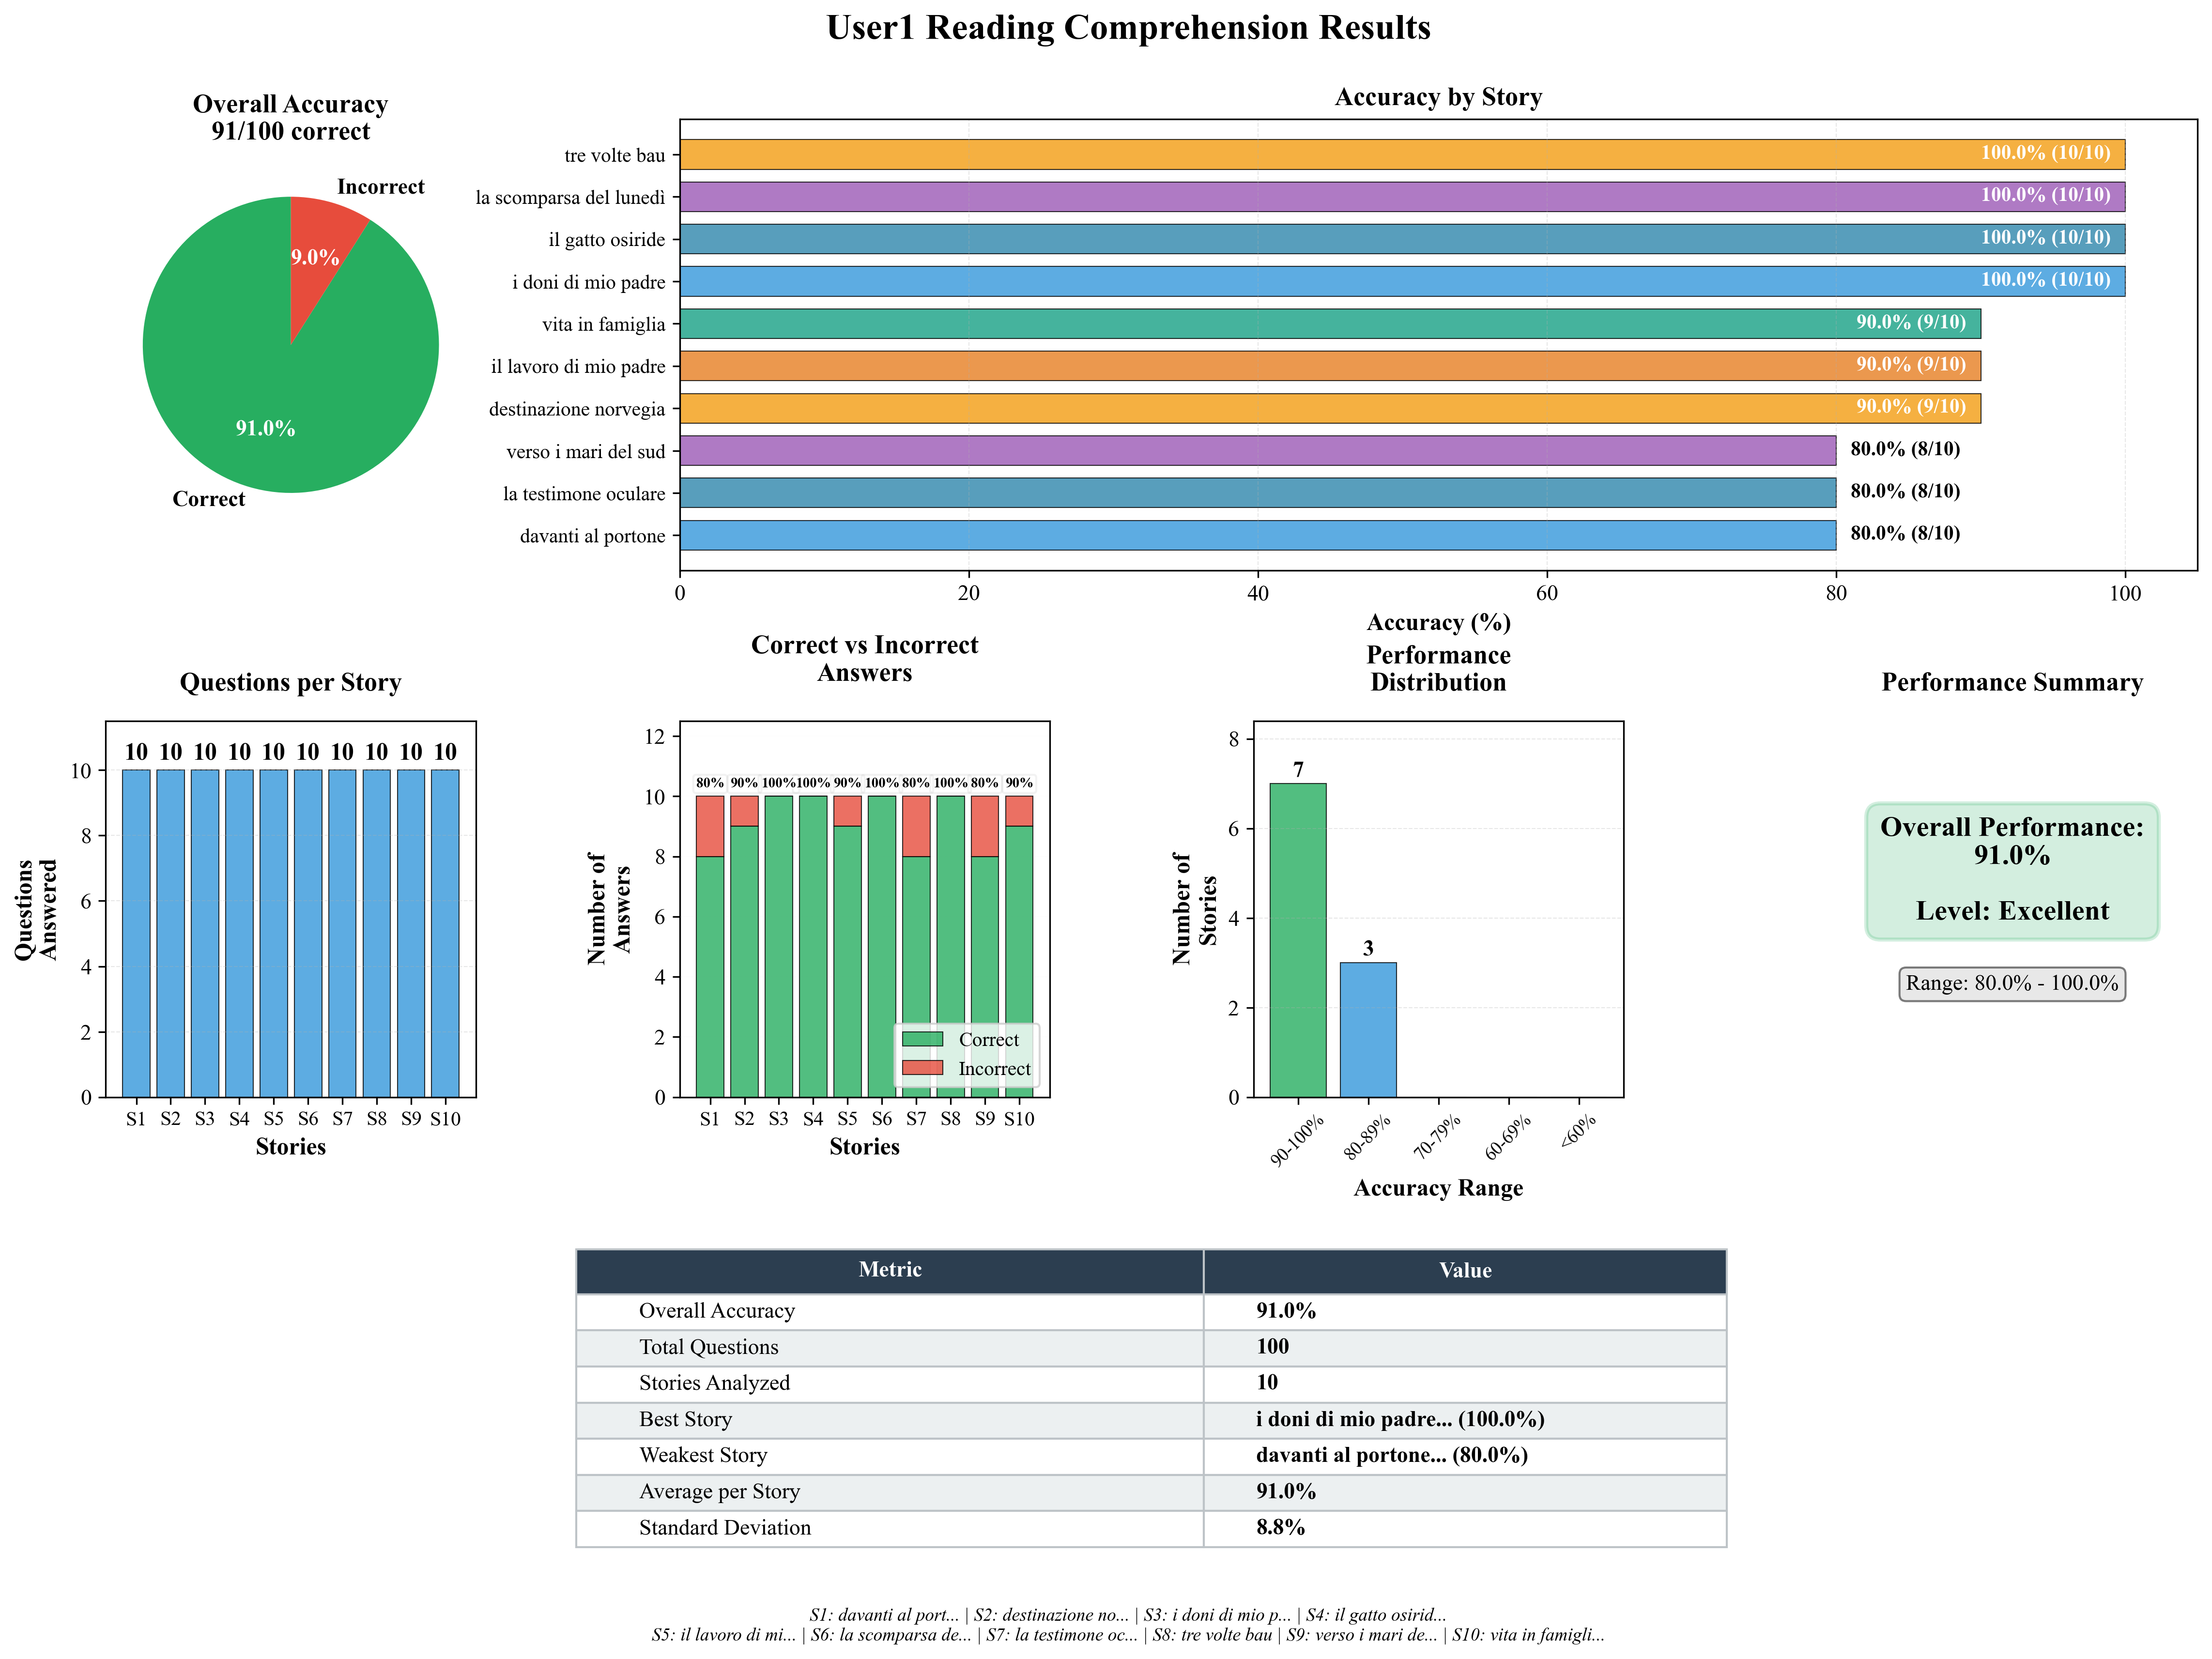

Generating summary...
USER1 PERFORMANCE ANALYSIS
Overall Accuracy: 91.0%
Questions Analyzed: 100
Stories Covered: 10
Question Coverage: 100/170 (58.8%)
Best Performance: 100.0% (i doni di mio padre)
Lowest Performance: 80.0% (davanti al portone)

Story-by-Story Breakdown:
• davanti al portone: 8/10 (80.0%)
• destinazione norvegia: 9/10 (90.0%)
• i doni di mio padre: 10/10 (100.0%)
• il gatto osiride: 10/10 (100.0%)
• il lavoro di mio padre: 9/10 (90.0%)
• la scomparsa del lunedì: 10/10 (100.0%)
• la testimone oculare: 8/10 (80.0%)
• tre volte bau: 10/10 (100.0%)
• verso i mari del sud: 8/10 (80.0%)
• vita in famiglia: 9/10 (90.0%)

Preparing temporal analysis...
Total stories/texts in data: 12
Processing stories/texts (excluding last 2): 10
Excluded texts: ['il gigante dahl', 'il conte dracula']

TEMPORAL ANALYSIS: IMPROVEMENT OVER TIME
Total attempts analyzed: 235
Date range: 2025-07-28 17:38:38 to 2025-10-10 14:26:11


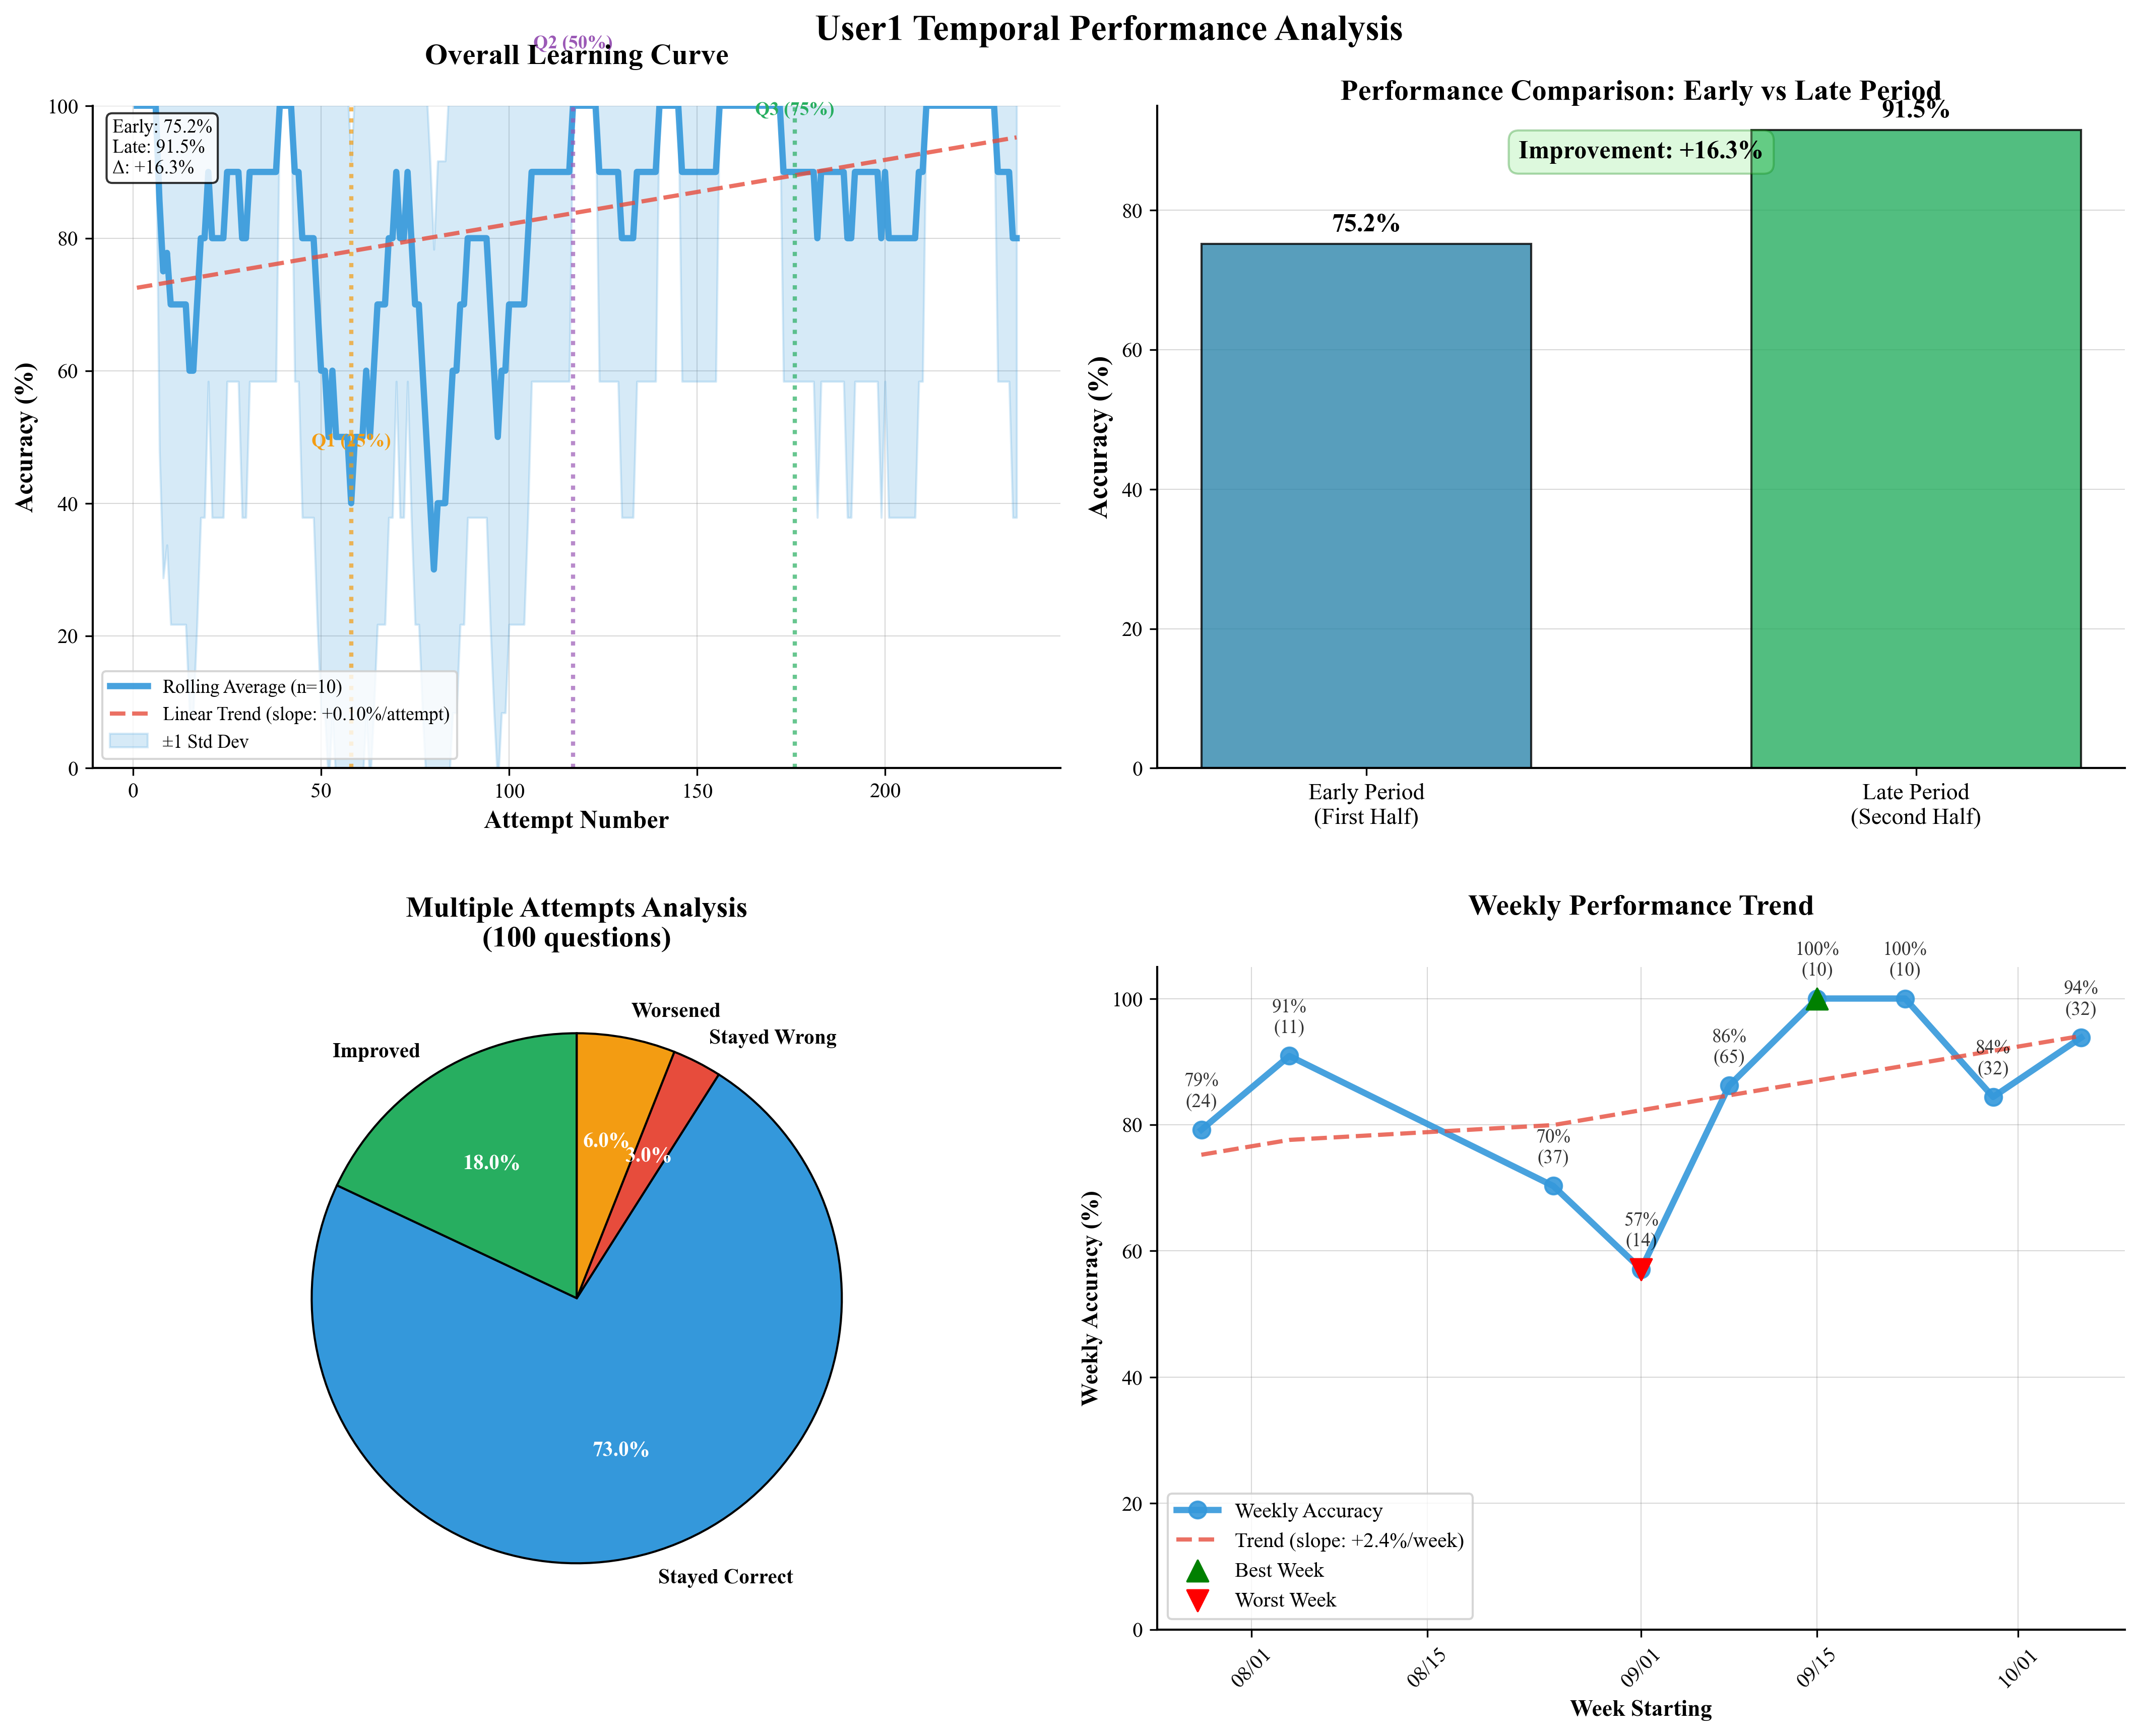


TEMPORAL STATISTICS:
First attempt date: 2025-07-28 17:38:38
Last attempt date: 2025-10-10 14:26:11
Total study period: 73 days
Total attempts: 235
Average attempts per day: 3.2

PERFORMANCE COMPARISON:
Early period accuracy (first 117 attempts): 75.2%
Late period accuracy (last 118 attempts): 91.5%
Improvement: +16.3 percentage points
✅ Significant improvement detected!

STORY-SPECIFIC TEMPORAL TRENDS:
verso i mari del sud: +9.1% change (22 attempts)
davanti al portone: -34.6% change (27 attempts)
destinazione norvegia: +0.0% change (22 attempts)
il gatto osiride: +18.2% change (22 attempts)
i doni di mio padre: +50.0% change (24 attempts)
vita in famiglia: +37.1% change (23 attempts)
la scomparsa del lunedì: +0.0% change (30 attempts)
tre volte bau: +1.5% change (23 attempts)
la testimone oculare: -8.2% change (21 attempts)
il lavoro di mio padre: -18.2% change (21 attempts)

MULTIPLE ATTEMPTS ANALYSIS:
Questions attempted multiple times: 100
Questions improved from wrong to right: 

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
import re
import csv
import os
from datetime import datetime


# Configure matplotlib for professional output
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def load_data():
    """Load and process user and golden datasets."""
    # Load datasets
    with open("/Users/Martina.Galletti/Downloads/dati-artis1/dati-json/risultati-user1.json", "r") as f:
        user_data = json.load(f)
    
    with open("/Users/Martina.Galletti/Downloads/dati-artis1/json-with-correct-answers/quinta-elementare_with_answers.json", "r") as f:
        golden_data = json.load(f)
    
    return user_data, golden_data

def process_user_data(user_data, exclude_last_n=2):
    """Process user data into DataFrame, optionally excluding the last N texts."""
    records = []
    
    # Handle both old (texts/exercises) and new (stories) structures
    stories_key = "stories" if "stories" in user_data else "texts"
    
    # Get all stories/texts and exclude the last N
    all_stories = user_data[stories_key]
    
    if exclude_last_n > 0 and len(all_stories) > exclude_last_n:
        stories_to_process = all_stories[:-exclude_last_n]  # Remove last N texts
        excluded_titles = [story["title"] for story in all_stories[-exclude_last_n:]]
        print(f"Total stories/texts in data: {len(all_stories)}")
        print(f"Processing stories/texts (excluding last {exclude_last_n}): {len(stories_to_process)}")
        print(f"Excluded texts: {excluded_titles}")
    else:
        stories_to_process = all_stories
        print(f"Processing all {len(all_stories)} stories/texts")
    
    for story in stories_to_process:
        title = story["title"]
        
        # Handle questions structure
        questions = story.get("questions", [])
        if not questions and "exercises" in story:
            # Old structure
            for exercise in story["exercises"]:
                questions.extend(exercise.get("questions", []))
        
        for q in questions:
            q_text = q["question"].strip()
            for ans in q.get("answers", []):
                start_time = ans["date"].split("->")[0].strip()
                date = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
                records.append({
                    "title": title,
                    "question": q_text,
                    "answer": ans["result"].strip().lower(),
                    "date": date
                })
    
    return pd.DataFrame(records)

def process_golden_data(golden_data):
    """Process golden data into DataFrame."""
    records = []
    
    # Handle both structures
    stories_key = "stories" if "stories" in golden_data else "texts"
    
    for story in golden_data[stories_key]:
        title = story["title"]
        
        # Handle questions structure
        questions = story.get("questions", [])
        if not questions and "exercises" in story:
            # Old structure
            for exercise in story["exercises"]:
                questions.extend(exercise.get("questions", []))
        
        for q in questions:
            q_text = q["question"].strip()
            correct_answer = q.get("correct_answer", {}).get("text", "").strip().lower()
            records.append({
                "title": title,
                "question": q_text,
                "correct_answer": correct_answer
            })
    
    return pd.DataFrame(records)

def filter_data(df_user):
    """Filter out vocabulary questions and keep only last attempts."""
    # Remove vocabulary questions
    df_filtered = df_user[~df_user['question'].str.contains("Cosa significa", case=False, na=False)].copy()
    
    # Keep only last attempt for each question
    df_last = df_filtered.sort_values('date').groupby(['title', 'question']).tail(1).reset_index(drop=True)
    
    return df_last

def calculate_accuracy(df_user, df_golden):
    """Calculate accuracy metrics."""
    # Merge datasets
    merged_df = df_user.merge(df_golden, on=['title', 'question'], how='inner')
    
    if len(merged_df) == 0:
        return None, None
    
    # Calculate accuracy
    merged_df['is_correct'] = merged_df['answer'] == merged_df['correct_answer']
    
    # Overall accuracy
    overall_accuracy = merged_df['is_correct'].mean() * 100
    
    # Story-level accuracy
    story_accuracy = merged_df.groupby('title')['is_correct'].agg(['count', 'sum', 'mean'])
    story_accuracy.columns = ['total_answers', 'correct_answers', 'accuracy']
    story_accuracy['accuracy_pct'] = story_accuracy['accuracy'] * 100
    
    return merged_df, story_accuracy

def prepare_temporal_data(df_user, df_golden, exclude_last_n=2):
    """Prepare data for temporal analysis, optionally excluding last N texts."""
    # Get user data with excluded texts for consistency
    user_data, _ = load_data()
    df_user_filtered = process_user_data(user_data, exclude_last_n=exclude_last_n)
    
    # Analyze ALL attempts (not just final answers) to see improvement
    df_user_all_attempts = df_user_filtered[~df_user_filtered['question'].str.contains("Cosa significa", case=False, na=False)].copy()
    
    # Merge with golden answers to get correctness for all attempts
    df_temporal = df_user_all_attempts.merge(df_golden, on=['title', 'question'], how='inner')
    df_temporal['is_correct'] = df_temporal['answer'] == df_temporal['correct_answer']
    
    # Sort by date for temporal analysis
    df_temporal = df_temporal.sort_values('date')
    
    return df_temporal

def create_temporal_plot(df_temporal):
    """Create comprehensive temporal performance visualization."""
    print("\nTEMPORAL ANALYSIS: IMPROVEMENT OVER TIME")
    print("=" * 60)
    print(f"Total attempts analyzed: {len(df_temporal)}")
    print(f"Date range: {df_temporal['date'].min()} to {df_temporal['date'].max()}")
    
    # Set professional plotting parameters
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
        'axes.linewidth': 1.0,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.edgecolor': 'black',
        'axes.labelcolor': 'black',
        'axes.axisbelow': True,
        'xtick.bottom': True,
        'ytick.left': True,
        'xtick.color': 'black',
        'ytick.color': 'black',
        'text.color': 'black',
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white',
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'grid.alpha': 0.3,
        'grid.color': 'gray'
    })
    
    # Calculate daily accuracy
    df_temporal['date_only'] = df_temporal['date'].dt.date
    daily_stats = df_temporal.groupby('date_only').agg({
        'is_correct': ['count', 'sum', 'mean']
    }).round(3)
    daily_stats.columns = ['total_attempts', 'correct_attempts', 'daily_accuracy']
    daily_stats['daily_accuracy_pct'] = daily_stats['daily_accuracy'] * 100
    
    # Create the temporal analysis plot
    fig = plt.figure(figsize=(16, 12), facecolor='white')
    
    # Create grid layout
    gs = fig.add_gridspec(2, 2, 
                         height_ratios=[1, 1], 
                         width_ratios=[1, 1],
                         hspace=0.3, 
                         wspace=0.1,
                         top=0.92,
                         bottom=0.08,
                         left=0.08,
                         right=0.92)
    
    # Professional color palette
    colors_comparison = ['#2E86AB', '#27AE60']
    colors_pie = ['#27AE60', '#3498DB', '#E74C3C', '#F39C12']
    
    # 1. Overall Learning Curve (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create overall learning curve with attempt sequence
    attempt_numbers = np.arange(1, len(df_temporal) + 1)
    rolling_window = min(10, len(df_temporal) // 4)  # Adaptive window size
    rolling_acc = df_temporal['is_correct'].rolling(window=rolling_window, min_periods=1).mean() * 100
    
    # Plot overall learning curve
    ax1.plot(attempt_numbers, rolling_acc, color='#3498DB', linewidth=3, alpha=0.9,
             label=f'Rolling Average (n={rolling_window})')
    
    # Add overall trend line
    if len(attempt_numbers) > 5:
        z = np.polyfit(attempt_numbers, rolling_acc, 1)
        p = np.poly1d(z)
        trend_line = p(attempt_numbers)
        ax1.plot(attempt_numbers, trend_line, "--", color='#E74C3C', alpha=0.8, linewidth=2,
                 label=f'Linear Trend (slope: {z[0]:+.2f}%/attempt)')
    
    # Highlight performance quartiles
    quartile_points = [len(attempt_numbers)//4, len(attempt_numbers)//2, 3*len(attempt_numbers)//4]
    quartile_colors = ['#F39C12', '#9B59B6', '#27AE60']
    quartile_labels = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    
    for i, (point, color, label) in enumerate(zip(quartile_points, quartile_colors, quartile_labels)):
        if point < len(rolling_acc):
            ax1.axvline(x=point, color=color, linestyle=':', alpha=0.7, linewidth=2)
            ax1.text(point, rolling_acc.iloc[point-1] + 8, label, 
                    ha='center', va='bottom', fontsize=9, color=color, fontweight='bold')
    
    # Add confidence band (standard deviation)
    rolling_std = df_temporal['is_correct'].rolling(window=rolling_window, min_periods=1).std() * 100
    ax1.fill_between(attempt_numbers, rolling_acc - rolling_std, rolling_acc + rolling_std,
                    alpha=0.2, color='#3498DB', label='±1 Std Dev')
    
    ax1.set_xlabel('Attempt Number', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
    ax1.set_title('Overall Learning Curve', fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.set_ylim(0, 100)
    ax1.legend(fontsize=9, frameon=True, fancybox=True, shadow=False, 
              bbox_to_anchor=(0, 0), loc='lower left')
    ax1.tick_params(axis='both', labelsize=10)
    
    # Add performance milestones text
    first_half_perf = df_temporal.iloc[:len(df_temporal)//2]['is_correct'].mean() * 100
    second_half_perf = df_temporal.iloc[len(df_temporal)//2:]['is_correct'].mean() * 100
    overall_improvement = second_half_perf - first_half_perf
    
    milestone_text = f"Early: {first_half_perf:.1f}%\nLate: {second_half_perf:.1f}%\nΔ: {overall_improvement:+.1f}%"
    ax1.text(0.02, 0.98, milestone_text, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # 2. Performance Comparison (Early vs Late) (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    total_attempts = len(df_temporal)
    early_attempts = df_temporal.iloc[:total_attempts//2]
    late_attempts = df_temporal.iloc[total_attempts//2:]
    
    early_accuracy = early_attempts['is_correct'].mean() * 100
    late_accuracy = late_attempts['is_correct'].mean() * 100
    
    # Create comparison bars
    periods = ['Early Period\n(First Half)', 'Late Period\n(Second Half)']
    accuracies = [early_accuracy, late_accuracy]
    
    bars = ax2.bar(periods, accuracies, color=colors_comparison, alpha=0.8, width=0.6, 
                   edgecolor='black', linewidth=1)
    ax2.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=13)
    ax2.set_title('Performance Comparison: Early vs Late Period', fontsize=14, fontweight='bold', pad=3)
    ax2.set_ylim(0, 95)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
    ax2.tick_params(axis='x', labelsize=11)
    ax2.tick_params(axis='y', labelsize=10)
    
    # Add value labels and improvement indicator
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Add improvement text
    improvement = late_accuracy - early_accuracy
    if improvement > 0:
        ax2.text(0.50, 0.93, f'Improvement: +{improvement:.1f}%', 
                transform=ax2.transAxes, ha='center', va='center', fontweight='bold', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.4", facecolor='lightgreen', alpha=0.3, edgecolor='green'))
    else:
        ax2.text(0.50, 0.93, f'Change: {improvement:.1f}%', 
                transform=ax2.transAxes, ha='center', va='center', fontweight='bold', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral', alpha=0.3, edgecolor='red'))
    
    # 3. Multiple Attempts Analysis (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    questions_with_multiple = df_temporal.groupby(['title', 'question']).size()
    multiple_attempts_questions = questions_with_multiple[questions_with_multiple > 1]
    
    if len(multiple_attempts_questions) > 0:
        # Analyze improvement patterns
        improvement_patterns = {'Improved': 0, 'Stayed Correct': 0, 'Stayed Wrong': 0, 'Worsened': 0}
        
        for (title, question), count in multiple_attempts_questions.items():
            question_attempts = df_temporal[
                (df_temporal['title'] == title) & 
                (df_temporal['question'] == question)
            ].sort_values('date')
            
            first_correct = question_attempts.iloc[0]['is_correct']
            last_correct = question_attempts.iloc[-1]['is_correct']
            
            if first_correct and last_correct:
                improvement_patterns['Stayed Correct'] += 1
            elif not first_correct and last_correct:
                improvement_patterns['Improved'] += 1
            elif not first_correct and not last_correct:
                improvement_patterns['Stayed Wrong'] += 1
            else:
                improvement_patterns['Worsened'] += 1
        
        # Create pie chart
        labels = list(improvement_patterns.keys())
        sizes = list(improvement_patterns.values())
        
        wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie,
                                          autopct='%1.1f%%', startangle=90,
                                          textprops={'fontsize': 11},
                                          wedgeprops={'edgecolor': 'black', 'linewidth': 1})
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)
        
        for text in texts:
            text.set_fontsize(10)
            text.set_fontweight('bold')
        
        ax3.set_title(f'Multiple Attempts Analysis\n({len(multiple_attempts_questions)} questions)', 
                      fontsize=14, fontweight='bold', pad=10)
        
    else:
        ax3.text(0.5, 0.5, 'No Multiple\nAttempts Found', ha='center', va='center',
                transform=ax3.transAxes, fontsize=14, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.5))
        ax3.set_title('Multiple Attempts Analysis', fontsize=14, fontweight='bold', pad=20)
    
    # 4. Weekly Trend Analysis (bottom right)
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Calculate weekly performance
    df_temporal['week_start'] = df_temporal['date'].dt.to_period('W').dt.start_time
    weekly_stats = df_temporal.groupby('week_start').agg({
        'is_correct': ['count', 'sum', 'mean']
    }).round(3)
    weekly_stats.columns = ['total_attempts', 'correct_attempts', 'weekly_accuracy']
    weekly_stats['weekly_accuracy_pct'] = weekly_stats['weekly_accuracy'] * 100
    
    # Filter weeks with at least 2 attempts for more reliable data
    weekly_stats_filtered = weekly_stats[weekly_stats['total_attempts'] >= 2]
    
    if len(weekly_stats_filtered) >= 2:
        # Plot weekly accuracy trend
        ax4.plot(weekly_stats_filtered.index, weekly_stats_filtered['weekly_accuracy_pct'], 
                 color='#3498DB', linewidth=3, marker='o', markersize=8, alpha=0.9,
                 label='Weekly Accuracy')
        
        # Add trend line
        x_numeric = np.arange(len(weekly_stats_filtered))
        z = np.polyfit(x_numeric, weekly_stats_filtered['weekly_accuracy_pct'], 1)
        p = np.poly1d(z)
        trend_line = p(x_numeric)
        ax4.plot(weekly_stats_filtered.index, trend_line, "--", color='#E74C3C', 
                 alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:+.1f}%/week)')
        
        # Highlight best and worst weeks
        best_week_idx = weekly_stats_filtered['weekly_accuracy_pct'].idxmax()
        worst_week_idx = weekly_stats_filtered['weekly_accuracy_pct'].idxmin()
        
        ax4.scatter([best_week_idx], [weekly_stats_filtered.loc[best_week_idx, 'weekly_accuracy_pct']], 
                   color='green', s=100, marker='^', zorder=5, label='Best Week')
        ax4.scatter([worst_week_idx], [weekly_stats_filtered.loc[worst_week_idx, 'weekly_accuracy_pct']], 
                   color='red', s=100, marker='v', zorder=5, label='Worst Week')
        
        # Add value labels for each point
        for idx, row in weekly_stats_filtered.iterrows():
            ax4.text(idx, row['weekly_accuracy_pct'] + 3, 
                    f"{row['weekly_accuracy_pct']:.0f}%\n({int(row['total_attempts'])})", 
                    ha='center', va='bottom', fontsize=9, alpha=0.8)
        
        ax4.set_xlabel('Week Starting', fontweight='bold', fontsize=11)
        ax4.set_ylabel('Weekly Accuracy (%)', fontweight='bold', fontsize=11)
        ax4.set_title('Weekly Performance Trend', fontsize=14, fontweight='bold', pad=25)
        ax4.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax4.set_ylim(0, 105)
        ax4.legend(fontsize=10, frameon=True, fancybox=True, shadow=False)
        
        # Format x-axis to show dates nicely
        ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax4.tick_params(axis='x', rotation=45, labelsize=10)
        ax4.tick_params(axis='y', labelsize=10)
        
    else:
        # Fallback for insufficient weekly data
        daily_stats_viz = daily_stats[daily_stats['total_attempts'] >= 1]
        
        ax4.bar(range(len(daily_stats_viz)), daily_stats_viz['daily_accuracy_pct'], 
               color='#3498DB', alpha=0.7, width=0.8)
        
        ax4.set_xlabel('Study Days', fontweight='bold', fontsize=13)
        ax4.set_ylabel('Daily Accuracy (%)', fontweight='bold', fontsize=13)
        ax4.set_title('Daily Performance Pattern', fontsize=14, fontweight='bold', pad=20)
        ax4.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
        ax4.set_ylim(0, 105)
        ax4.set_xticks(range(len(daily_stats_viz)))
        ax4.set_xticklabels([f'Day {i+1}' for i in range(len(daily_stats_viz))], fontsize=10)
        
        # Add value labels on bars
        for i, (idx, row) in enumerate(daily_stats_viz.iterrows()):
            ax4.text(i, row['daily_accuracy_pct'] + 2, 
                    f"{row['daily_accuracy_pct']:.0f}%", 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax4.tick_params(axis='both', labelsize=10)
    
    # Add main title
    fig.suptitle('User1 Temporal Performance Analysis', 
                fontsize=17, fontweight='bold', y=0.97, ha='center')
    
    plt.show()
    
    # Reset matplotlib parameters to default
    plt.rcParams.update(plt.rcParamsDefault)
    
    return early_accuracy, late_accuracy, improvement, multiple_attempts_questions

def print_temporal_summary(df_temporal, early_accuracy, late_accuracy, improvement, multiple_attempts_questions):
    """Print detailed temporal statistics."""
    total_attempts = len(df_temporal)
    early_attempts = df_temporal.iloc[:total_attempts//2]
    late_attempts = df_temporal.iloc[total_attempts//2:]
    
    print("\nTEMPORAL STATISTICS:")
    print("=" * 40)
    print(f"First attempt date: {df_temporal['date'].min()}")
    print(f"Last attempt date: {df_temporal['date'].max()}")
    print(f"Total study period: {(df_temporal['date'].max() - df_temporal['date'].min()).days} days")
    print(f"Total attempts: {len(df_temporal)}")
    print(f"Average attempts per day: {len(df_temporal) / max(1, (df_temporal['date'].max() - df_temporal['date'].min()).days):.1f}")
    
    print(f"\nPERFORMANCE COMPARISON:")
    print(f"Early period accuracy (first {len(early_attempts)} attempts): {early_accuracy:.1f}%")
    print(f"Late period accuracy (last {len(late_attempts)} attempts): {late_accuracy:.1f}%")
    print(f"Improvement: {improvement:+.1f} percentage points")
    
    if improvement > 5:
        print("✅ Significant improvement detected!")
    elif improvement > 0:
        print("📈 Slight improvement detected")
    elif improvement > -5:
        print("📊 Performance remained stable")
    else:
        print("📉 Performance declined")
    
    # Story-specific temporal analysis
    print(f"\nSTORY-SPECIFIC TEMPORAL TRENDS:")
    print("=" * 40)
    
    for title in df_temporal['title'].unique():
        story_data = df_temporal[df_temporal['title'] == title].sort_values('date')
        if len(story_data) > 1:
            first_accuracy = story_data.iloc[:len(story_data)//2]['is_correct'].mean() * 100
            last_accuracy = story_data.iloc[len(story_data)//2:]['is_correct'].mean() * 100
            story_trend = last_accuracy - first_accuracy
            print(f"{title[:30]}: {story_trend:+.1f}% change ({len(story_data)} attempts)")
    
    # Multiple attempts analysis
    if len(multiple_attempts_questions) > 0:
        print(f"\nMULTIPLE ATTEMPTS ANALYSIS:")
        print("=" * 40)
        print(f"Questions attempted multiple times: {len(multiple_attempts_questions)}")
        
        # Analyze improvement in repeated questions
        improvement_count = 0
        total_repeated = 0
        
        for (title, question), count in multiple_attempts_questions.items():
            question_attempts = df_temporal[
                (df_temporal['title'] == title) & 
                (df_temporal['question'] == question)
            ].sort_values('date')
            
            first_correct = question_attempts.iloc[0]['is_correct']
            last_correct = question_attempts.iloc[-1]['is_correct']
            
            if last_correct and not first_correct:
                improvement_count += 1
            total_repeated += 1
        
        improvement_rate = (improvement_count / total_repeated) * 100 if total_repeated > 0 else 0
        print(f"Questions improved from wrong to right: {improvement_count}/{total_repeated} ({improvement_rate:.1f}%)")

def create_professional_plot(merged_df, story_accuracy, df_user, df_golden):
    """Create comprehensive performance visualization."""
    fig = plt.figure(figsize=(16, 12))
    
    # Create improved grid layout with better spacing
    gs = fig.add_gridspec(3, 4, 
                         height_ratios=[1.2, 1, 0.8], 
                         width_ratios=[1, 1, 1, 1],
                         hspace=0.4, wspace=0.55,
                         top=0.90, bottom=0.08,
                         left=0.06, right=0.96)
    
    # Updated color scheme to match temporal analysis
    colors_accuracy = ['#27AE60', '#E74C3C']  # Green/Red for correct/incorrect
    colors_main = ['#3498DB', '#2E86AB', '#9B59B6', '#F39C12', '#E67E22', '#16A085']  # Blues, purples, oranges, teal
    colors_performance_ranges = ['#27AE60', '#3498DB', '#F39C12', '#E67E22', '#E74C3C']  # Green to red gradient
    
    # 1. Overall Accuracy Pie Chart (top left) - keeping existing colors_accuracy
    ax1 = fig.add_subplot(gs[0, 0])
    correct_count = merged_df['is_correct'].sum()
    incorrect_count = len(merged_df) - correct_count
    
    wedges, texts, autotexts = ax1.pie([correct_count, incorrect_count], 
                                      labels=['Correct', 'Incorrect'],
                                      colors=colors_accuracy,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      textprops={'fontsize': 12, 'fontweight': 'bold'})

    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    
    for text in texts:
        text.set_fontweight('bold')
        text.set_fontsize(11)
    
    ax1.set_title(f'Overall Accuracy\n{correct_count}/{len(merged_df)} correct', 
                  fontweight='bold', pad=10, fontsize=13)
    
    # 2. Accuracy by Story - using new colors_main
    ax2 = fig.add_subplot(gs[0, 1:])
    story_accuracy_sorted = story_accuracy.sort_values('accuracy_pct', ascending=True)
    
    y_pos = range(len(story_accuracy_sorted))
    bars = ax2.barh(y_pos, story_accuracy_sorted['accuracy_pct'], 
                   color=colors_main[:len(story_accuracy_sorted)], 
                   alpha=0.8, height=0.7, edgecolor='black', linewidth=0.5)
    
    
    ax2.set_yticks(y_pos)
    # Improved story labels with better truncation
    story_labels = []
    for title in story_accuracy_sorted.index:
        if len(title) > 35:
            story_labels.append(title[:32] + '...')
        else:
            story_labels.append(title)
    ax2.set_yticklabels(story_labels, fontsize=10)
    
    ax2.set_xlabel('Accuracy (%)', fontweight='bold', fontsize=12)
    ax2.set_title('Accuracy by Story', fontweight='bold', pad=7, fontsize=13)
    ax2.set_xlim(0, 105)
    ax2.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Enhanced value labels with question counts
    for i, (bar, (title, row)) in enumerate(zip(bars, story_accuracy_sorted.iterrows())):
        value = row['accuracy_pct']
        total_q = int(row['total_answers'])
        correct_q = int(row['correct_answers'])
        
        # Position label based on bar length
        x_pos = value + 1 if value < 85 else value - 1
        ha_align = 'left' if value < 85 else 'right'
        text_color = 'black' if value < 85 else 'white'
        
        ax2.text(x_pos, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}% ({correct_q}/{total_q})', 
                ha=ha_align, va='center', fontweight='bold', 
                fontsize=10, color=text_color)
    
    # 3. Questions per Story (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    question_counts = story_accuracy['total_answers']
    
    bars3 = ax3.bar(range(len(question_counts)), question_counts, 
                   color='#3498DB', alpha=0.8, edgecolor='black', linewidth=0.5)  # Changed to temporal blue
    
    
    ax3.set_xlabel('Stories', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Questions\nAnswered', fontweight='bold', fontsize=12)
    ax3.set_title('Questions per Story', fontweight='bold', pad=15, fontsize=13)
    ax3.set_xticks(range(len(question_counts)))
    ax3.set_xticklabels([f'S{i+1}' for i in range(len(question_counts))], fontsize=10)
    ax3.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Enhanced value labels for question counts
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.15,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=12)
    
    # Set y-axis to start from 0 with better spacing
    ax3.set_ylim(0, max(question_counts) * 1.15)
    
    # 4. Correct vs Incorrect Stacked Bar Chart (bottom middle)
    ax4 = fig.add_subplot(gs[1, 1])
    performance_data = []
    
    for title, row in story_accuracy.iterrows():
        correct = int(row['correct_answers'])
        total = int(row['total_answers'])
        incorrect = total - correct
        performance_data.append([correct, incorrect])
    
    performance_array = np.array(performance_data).T
    
    bars_correct = ax4.bar(range(len(story_accuracy)), performance_array[0], 
                          label='Correct', color=colors_accuracy[0], alpha=0.8,
                          edgecolor='black', linewidth=0.5)
    bars_incorrect = ax4.bar(range(len(story_accuracy)), performance_array[1], 
                           bottom=performance_array[0], label='Incorrect', 
                           color=colors_accuracy[1], alpha=0.8,
                           edgecolor='black', linewidth=0.5)
    
    ax4.set_xlabel('Stories', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Number of\nAnswers', fontweight='bold', fontsize=12)
    ax4.set_title('Correct vs Incorrect\nAnswers', fontweight='bold', pad=20, fontsize=13)
    ax4.set_xticks(range(len(story_accuracy)))
    ax4.set_xticklabels([f'S{i+1}' for i in range(len(story_accuracy))], fontsize=10)
    ax4.legend(loc='lower right', fontsize=10)
    ax4.grid(axis='y', alpha=0.1, linestyle='--', linewidth=0.1)
    
    # Enhanced percentage labels with better positioning and white background
    for i, (correct, total) in enumerate(zip(performance_array[0], 
                                           performance_array[0] + performance_array[1])):
        if total > 0:
            percentage = (correct / total) * 100
            # Position label above the bar
            y_pos = total + max(performance_array[0] + performance_array[1]) * 0.02
            ax4.text(i, y_pos, f'{percentage:.0f}%', 
                    ha='center', va='bottom', fontweight='bold', 
                    fontsize=7, color='black',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                             alpha=0.1, edgecolor='gray', linewidth=1))
    
    # Set y-axis limits with better spacing
    max_total = max(performance_array[0] + performance_array[1])
    ax4.set_ylim(0, max_total * 1.25)
    
    # 5. Performance Distribution (bottom middle-right)
    ax5 = fig.add_subplot(gs[1, 2])
    
    # Create performance ranges
    ranges = ['90-100%', '80-89%', '70-79%', '60-69%', '<60%']
    range_counts = [0, 0, 0, 0, 0]
    
    for acc in story_accuracy['accuracy_pct']:
        if acc >= 90:
            range_counts[0] += 1
        elif acc >= 80:
            range_counts[1] += 1
        elif acc >= 70:
            range_counts[2] += 1
        elif acc >= 60:
            range_counts[3] += 1
        else:
            range_counts[4] += 1
    
    bars5 = ax5.bar(ranges, range_counts, color=colors_performance_ranges, alpha=0.8,
                   edgecolor='black', linewidth=0.5)
    
    
    ax5.set_xlabel('Accuracy Range', fontweight='bold', fontsize=12)
    ax5.set_ylabel('Number of\nStories', fontweight='bold', fontsize=12)
    ax5.set_title('Performance\nDistribution', fontweight='bold', pad=15, fontsize=13)
    ax5.tick_params(axis='x', rotation=45, labelsize=9)
    ax5.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add value labels on bars
    for bar, count in zip(bars5, range_counts):
        if count > 0:
            ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                    f'{count}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=11)
    
    ax5.set_ylim(0, max(max(range_counts), 1) * 1.2)
    
    # 6. Performance Summary (bottom right)
    ax6 = fig.add_subplot(gs[1, 3])
    ax6.axis('off')
    
    overall_accuracy = merged_df['is_correct'].mean() * 100
    
    
    # Create performance summary text
    performance_level = ""
    if overall_accuracy >= 90:
        performance_level = "Excellent"
        level_color = '#27AE60'  # Consistent green
    elif overall_accuracy >= 80:
        performance_level = "Good" 
        level_color = '#3498DB'  # Consistent blue
    elif overall_accuracy >= 70:
        performance_level = "Fair"
        level_color = '#F39C12'  # Consistent orange
    elif overall_accuracy >= 60:
        performance_level = "Below Average"
        level_color = '#E67E22'  # Darker orange
    else:
        performance_level = "Needs Improvement"
        level_color = '#E74C3C' 
    
    # Display performance summary
    summary_text = f"Overall Performance:\n{overall_accuracy:.1f}%\n\nLevel: {performance_level}"
    
    ax6.text(0.5, 0.6, summary_text, ha='center', va='center', 
             fontsize=14, fontweight='bold', transform=ax6.transAxes,
             bbox=dict(boxstyle="round,pad=0.5", facecolor=level_color, 
                      alpha=0.2, edgecolor=level_color, linewidth=2))
    
    # Add additional stats
    best_story_acc = story_accuracy['accuracy_pct'].max()
    worst_story_acc = story_accuracy['accuracy_pct'].min()
    range_text = f"Range: {worst_story_acc:.1f}% - {best_story_acc:.1f}%"
    
    ax6.text(0.5, 0.3, range_text, ha='center', va='center',
             fontsize=11, transform=ax6.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.5))
    
    ax6.set_title('Performance Summary', fontweight='bold', pad=15, fontsize=13)
    
    # 7. Summary Statistics Table (bottom, full width)
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('off')
    
    summary_stats = [
        ['Overall Accuracy', f'{overall_accuracy:.1f}%'],
        ['Total Questions', f'{len(merged_df)}'],
        ['Stories Analyzed', f'{len(story_accuracy)}'],
        ['Best Story', f'{story_accuracy["accuracy_pct"].idxmax()[:30]}... ({story_accuracy["accuracy_pct"].max():.1f}%)'],
        ['Weakest Story', f'{story_accuracy["accuracy_pct"].idxmin()[:30]}... ({story_accuracy["accuracy_pct"].min():.1f}%)'],
        ['Average per Story', f'{story_accuracy["accuracy_pct"].mean():.1f}%'],
        ['Standard Deviation', f'{story_accuracy["accuracy_pct"].std():.1f}%'],
    ]
    
    # Create table with better formatting
    table = ax7.table(cellText=summary_stats,
                     colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center',
                     colWidths=[0.3, 0.25])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.8)
    
    # Enhanced table styling
    for i in range(len(summary_stats) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#2C3E50')
                cell.set_text_props(weight='bold', color='white')
                cell.set_height(0.15)
            else:
                cell.set_facecolor('#ECF0F1' if i % 2 == 0 else 'white')
                if j == 1:  # Value column
                    cell.set_text_props(weight='bold')
                cell.set_height(0.12)
            cell.set_edgecolor('#BDC3C7')
            cell.set_linewidth(1)
    
    # Add enhanced titles and legends
    fig.suptitle('User1 Reading Comprehension Results', 
                fontsize=18, fontweight='bold', y=0.96, ha='center')
    
    # Create a more detailed story legend
    story_legend_parts = []
    for i, title in enumerate(story_accuracy.index):
        short_title = title[:15] + '...' if len(title) > 15 else title
        story_legend_parts.append(f"S{i+1}: {short_title}")
    
    # Split legend into multiple lines if too many stories
    if len(story_legend_parts) > 4:
        legend_line1 = " | ".join(story_legend_parts[:4])
        legend_line2 = " | ".join(story_legend_parts[4:])
        story_legend = legend_line1 + "\n" + legend_line2
    else:
        story_legend = " | ".join(story_legend_parts)
    
    fig.text(0.5, 0.025, story_legend, ha='center', fontsize=9, 
             style='italic', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_summary(merged_df, story_accuracy, df_user, df_golden):
    """Print comprehensive summary statistics."""
    if merged_df is None:
        print("No matching data found for analysis!")
        return
    
    overall_accuracy = merged_df['is_correct'].mean() * 100
    user_questions = len(set(df_user[['title', 'question']].apply(tuple, axis=1)))
    golden_questions = len(set(df_golden[['title', 'question']].apply(tuple, axis=1)))
    
    print("USER1 PERFORMANCE ANALYSIS")
    print("=" * 50)
    print(f"Overall Accuracy: {overall_accuracy:.1f}%")
    print(f"Questions Analyzed: {len(merged_df)}")
    print(f"Stories Covered: {len(story_accuracy)}")
    print(f"Question Coverage: {user_questions}/{golden_questions} ({(user_questions/golden_questions)*100:.1f}%)")
    print(f"Best Performance: {story_accuracy['accuracy_pct'].max():.1f}% ({story_accuracy['accuracy_pct'].idxmax()})")
    print(f"Lowest Performance: {story_accuracy['accuracy_pct'].min():.1f}% ({story_accuracy['accuracy_pct'].idxmin()})")
    
    print(f"\nStory-by-Story Breakdown:")
    for title, row in story_accuracy.iterrows():
        print(f"• {title}: {int(row['correct_answers'])}/{int(row['total_answers'])} ({row['accuracy_pct']:.1f}%)")

def save_results_to_csv(merged_df, story_accuracy, df_temporal, overall_accuracy, 
                       early_accuracy, late_accuracy, improvement, multiple_attempts_questions,
                       output_dir="/Users/Martina.Galletti/Downloads/dati-artis1/user1/results"):
    """Save all analysis results to CSV files."""
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Overall Summary CSV
    summary_file = os.path.join(output_dir, f"user1_summary_{timestamp}.csv")
    with open(summary_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Metric', 'Value'])
        writer.writerow(['Overall Accuracy (%)', f'{overall_accuracy:.1f}'])
        writer.writerow(['Total Questions Analyzed', len(merged_df)])
        writer.writerow(['Total Stories', len(story_accuracy)])
        writer.writerow(['Best Story Accuracy (%)', f'{story_accuracy["accuracy_pct"].max():.1f}'])
        writer.writerow(['Worst Story Accuracy (%)', f'{story_accuracy["accuracy_pct"].min():.1f}'])
        writer.writerow(['Average Story Accuracy (%)', f'{story_accuracy["accuracy_pct"].mean():.1f}'])
        writer.writerow(['Standard Deviation (%)', f'{story_accuracy["accuracy_pct"].std():.1f}'])
        writer.writerow(['Best Story Title', story_accuracy["accuracy_pct"].idxmax()])
        writer.writerow(['Worst Story Title', story_accuracy["accuracy_pct"].idxmin()])
        writer.writerow(['Early Period Accuracy (%)', f'{early_accuracy:.1f}'])
        writer.writerow(['Late Period Accuracy (%)', f'{late_accuracy:.1f}'])
        writer.writerow(['Temporal Improvement (%)', f'{improvement:+.1f}'])
        writer.writerow(['Questions with Multiple Attempts', len(multiple_attempts_questions)])
        writer.writerow(['Analysis Date', timestamp])
    
    # 2. Story-by-Story Results CSV
    stories_file = os.path.join(output_dir, f"user1_stories_{timestamp}.csv")
    story_results = story_accuracy.copy()
    story_results['story_title'] = story_results.index
    story_results = story_results.reset_index(drop=True)
    story_results = story_results[['story_title', 'total_answers', 'correct_answers', 'accuracy_pct']]
    story_results.columns = ['Story_Title', 'Total_Questions', 'Correct_Answers', 'Accuracy_Percent']
    story_results.to_csv(stories_file, index=False, encoding='utf-8')
    
    # 3. Detailed Question-by-Question Results CSV
    questions_file = os.path.join(output_dir, f"user1_questions_{timestamp}.csv")
    question_results = merged_df[['title', 'question', 'answer', 'correct_answer', 'is_correct']].copy()
    question_results.columns = ['Story_Title', 'Question', 'User_Answer', 'Correct_Answer', 'Is_Correct']
    question_results.to_csv(questions_file, index=False, encoding='utf-8')
    
    # 4. Temporal Analysis CSV
    if len(df_temporal) > 0:
        temporal_file = os.path.join(output_dir, f"user1_temporal_{timestamp}.csv")
        temporal_results = df_temporal[['title', 'question', 'answer', 'correct_answer', 'is_correct', 'date']].copy()
        temporal_results.columns = ['Story_Title', 'Question', 'User_Answer', 'Correct_Answer', 'Is_Correct', 'Date']
        temporal_results.to_csv(temporal_file, index=False, encoding='utf-8')
        
        # 5. Daily Performance CSV
        daily_file = os.path.join(output_dir, f"user1_daily_{timestamp}.csv")
        df_temporal['date_only'] = df_temporal['date'].dt.date
        daily_stats = df_temporal.groupby('date_only').agg({
            'is_correct': ['count', 'sum', 'mean']
        }).round(3)
        daily_stats.columns = ['total_attempts', 'correct_attempts', 'daily_accuracy']
        daily_stats['daily_accuracy_pct'] = daily_stats['daily_accuracy'] * 100
        daily_stats['date'] = daily_stats.index
        daily_stats = daily_stats.reset_index(drop=True)
        daily_stats = daily_stats[['date', 'total_attempts', 'correct_attempts', 'daily_accuracy_pct']]
        daily_stats.columns = ['Date', 'Total_Attempts', 'Correct_Attempts', 'Daily_Accuracy_Percent']
        daily_stats.to_csv(daily_file, index=False, encoding='utf-8')
    
    # 6. Performance Distribution CSV
    distribution_file = os.path.join(output_dir, f"user1_distribution_{timestamp}.csv")
    ranges = ['90-100%', '80-89%', '70-79%', '60-69%', '<60%']
    range_counts = [0, 0, 0, 0, 0]
    
    for acc in story_accuracy['accuracy_pct']:
        if acc >= 90:
            range_counts[0] += 1
        elif acc >= 80:
            range_counts[1] += 1
        elif acc >= 70:
            range_counts[2] += 1
        elif acc >= 60:
            range_counts[3] += 1
        else:
            range_counts[4] += 1
    
    with open(distribution_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy_Range', 'Number_of_Stories'])
        for range_name, count in zip(ranges, range_counts):
            writer.writerow([range_name, count])
    
    # 7. Multiple Attempts Analysis CSV
    if len(multiple_attempts_questions) > 0:
        multiple_attempts_file = os.path.join(output_dir, f"user1_multiple_attempts_{timestamp}.csv")
        with open(multiple_attempts_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['Story_Title', 'Question', 'Attempt_Count', 'First_Correct', 'Last_Correct', 'Improvement_Pattern'])
            
            for (title, question), count in multiple_attempts_questions.items():
                question_attempts = df_temporal[
                    (df_temporal['title'] == title) & 
                    (df_temporal['question'] == question)
                ].sort_values('date')
                
                first_correct = question_attempts.iloc[0]['is_correct']
                last_correct = question_attempts.iloc[-1]['is_correct']
                
                if first_correct and last_correct:
                    pattern = 'Stayed Correct'
                elif not first_correct and last_correct:
                    pattern = 'Improved'
                elif not first_correct and not last_correct:
                    pattern = 'Stayed Wrong'
                else:
                    pattern = 'Worsened'
                
                writer.writerow([title, question, count, first_correct, last_correct, pattern])
    
    print(f"\nCSV FILES SAVED TO: {output_dir}")
    print("=" * 60)
    print(f"1. Summary: user1_summary_{timestamp}.csv")
    print(f"2. Story Results: user1_stories_{timestamp}.csv")
    print(f"3. Question Details: user1_questions_{timestamp}.csv")
    if len(df_temporal) > 0:
        print(f"4. Temporal Data: user1_temporal_{timestamp}.csv")
        print(f"5. Daily Performance: user1_daily_{timestamp}.csv")
    print(f"6. Performance Distribution: user1_distribution_{timestamp}.csv")
    if len(multiple_attempts_questions) > 0:
        print(f"7. Multiple Attempts: user1_multiple_attempts_{timestamp}.csv")
    
    return output_dir

# Update your main function to use the new parameter
# Update the main function to include CSV export
def main():
    print("Loading data...")
    user_data, golden_data = load_data()
    
    print("Processing datasets...")
    df_user = process_user_data(user_data, exclude_last_n=2)
    df_golden = process_golden_data(golden_data)
    
    print("Filtering data (removing vocabulary questions, keeping last attempts)...")
    df_user_clean = filter_data(df_user)
    
    print("Calculating accuracy...")
    merged_df, story_accuracy = calculate_user_accuracy_improvement(df_user_clean, df_golden)
    
    if merged_df is not None:
        overall_accuracy = merged_df['is_correct'].mean() * 100
        
        print("Creating performance visualization...")
        create_professional_plot(merged_df, story_accuracy, df_user_clean, df_golden)
        
        print("Generating summary...")
        print_summary(merged_df, story_accuracy, df_user_clean, df_golden)
        
        # Temporal analysis
        print("\nPreparing temporal analysis...")
        df_temporal = prepare_temporal_data(df_user, df_golden)
        
        if len(df_temporal) > 0:
            early_accuracy, late_accuracy, improvement, multiple_attempts_questions = create_temporal_plot(df_temporal)
            print_temporal_summary(df_temporal, early_accuracy, late_accuracy, improvement, multiple_attempts_questions)
            
            # Save results to CSV
            print("\nSaving results to CSV files...")
            output_dir = save_results_to_csv(
                merged_df, story_accuracy, df_temporal, overall_accuracy,
                early_accuracy, late_accuracy, improvement, multiple_attempts_questions
            )
            
        else:
            print("No temporal data available for analysis!")
            # Save basic results without temporal data
            output_dir = save_results_to_csv(
                merged_df, story_accuracy, pd.DataFrame(), overall_accuracy,
                0, 0, 0, {}
            )
        
    else:
        print("No matching questions found for analysis!")

# Run analysis
main()

Loading data...
Successfully loaded data from: /Users/Martina.Galletti/Downloads/dati-artis1
Processing datasets...
Total stories/texts in data: 12
Processing stories/texts (excluding last 2): 10
Excluded texts: ['il gigante dahl', 'il conte dracula']
Filtering data (removing vocabulary questions, keeping last attempts)...
Calculating accuracy...
Creating performance visualization...


/var/folders/xg/275fmmmx52b3sq21l50dn4yw0000gn/T/ipykernel_57728/1949817201.py:818: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


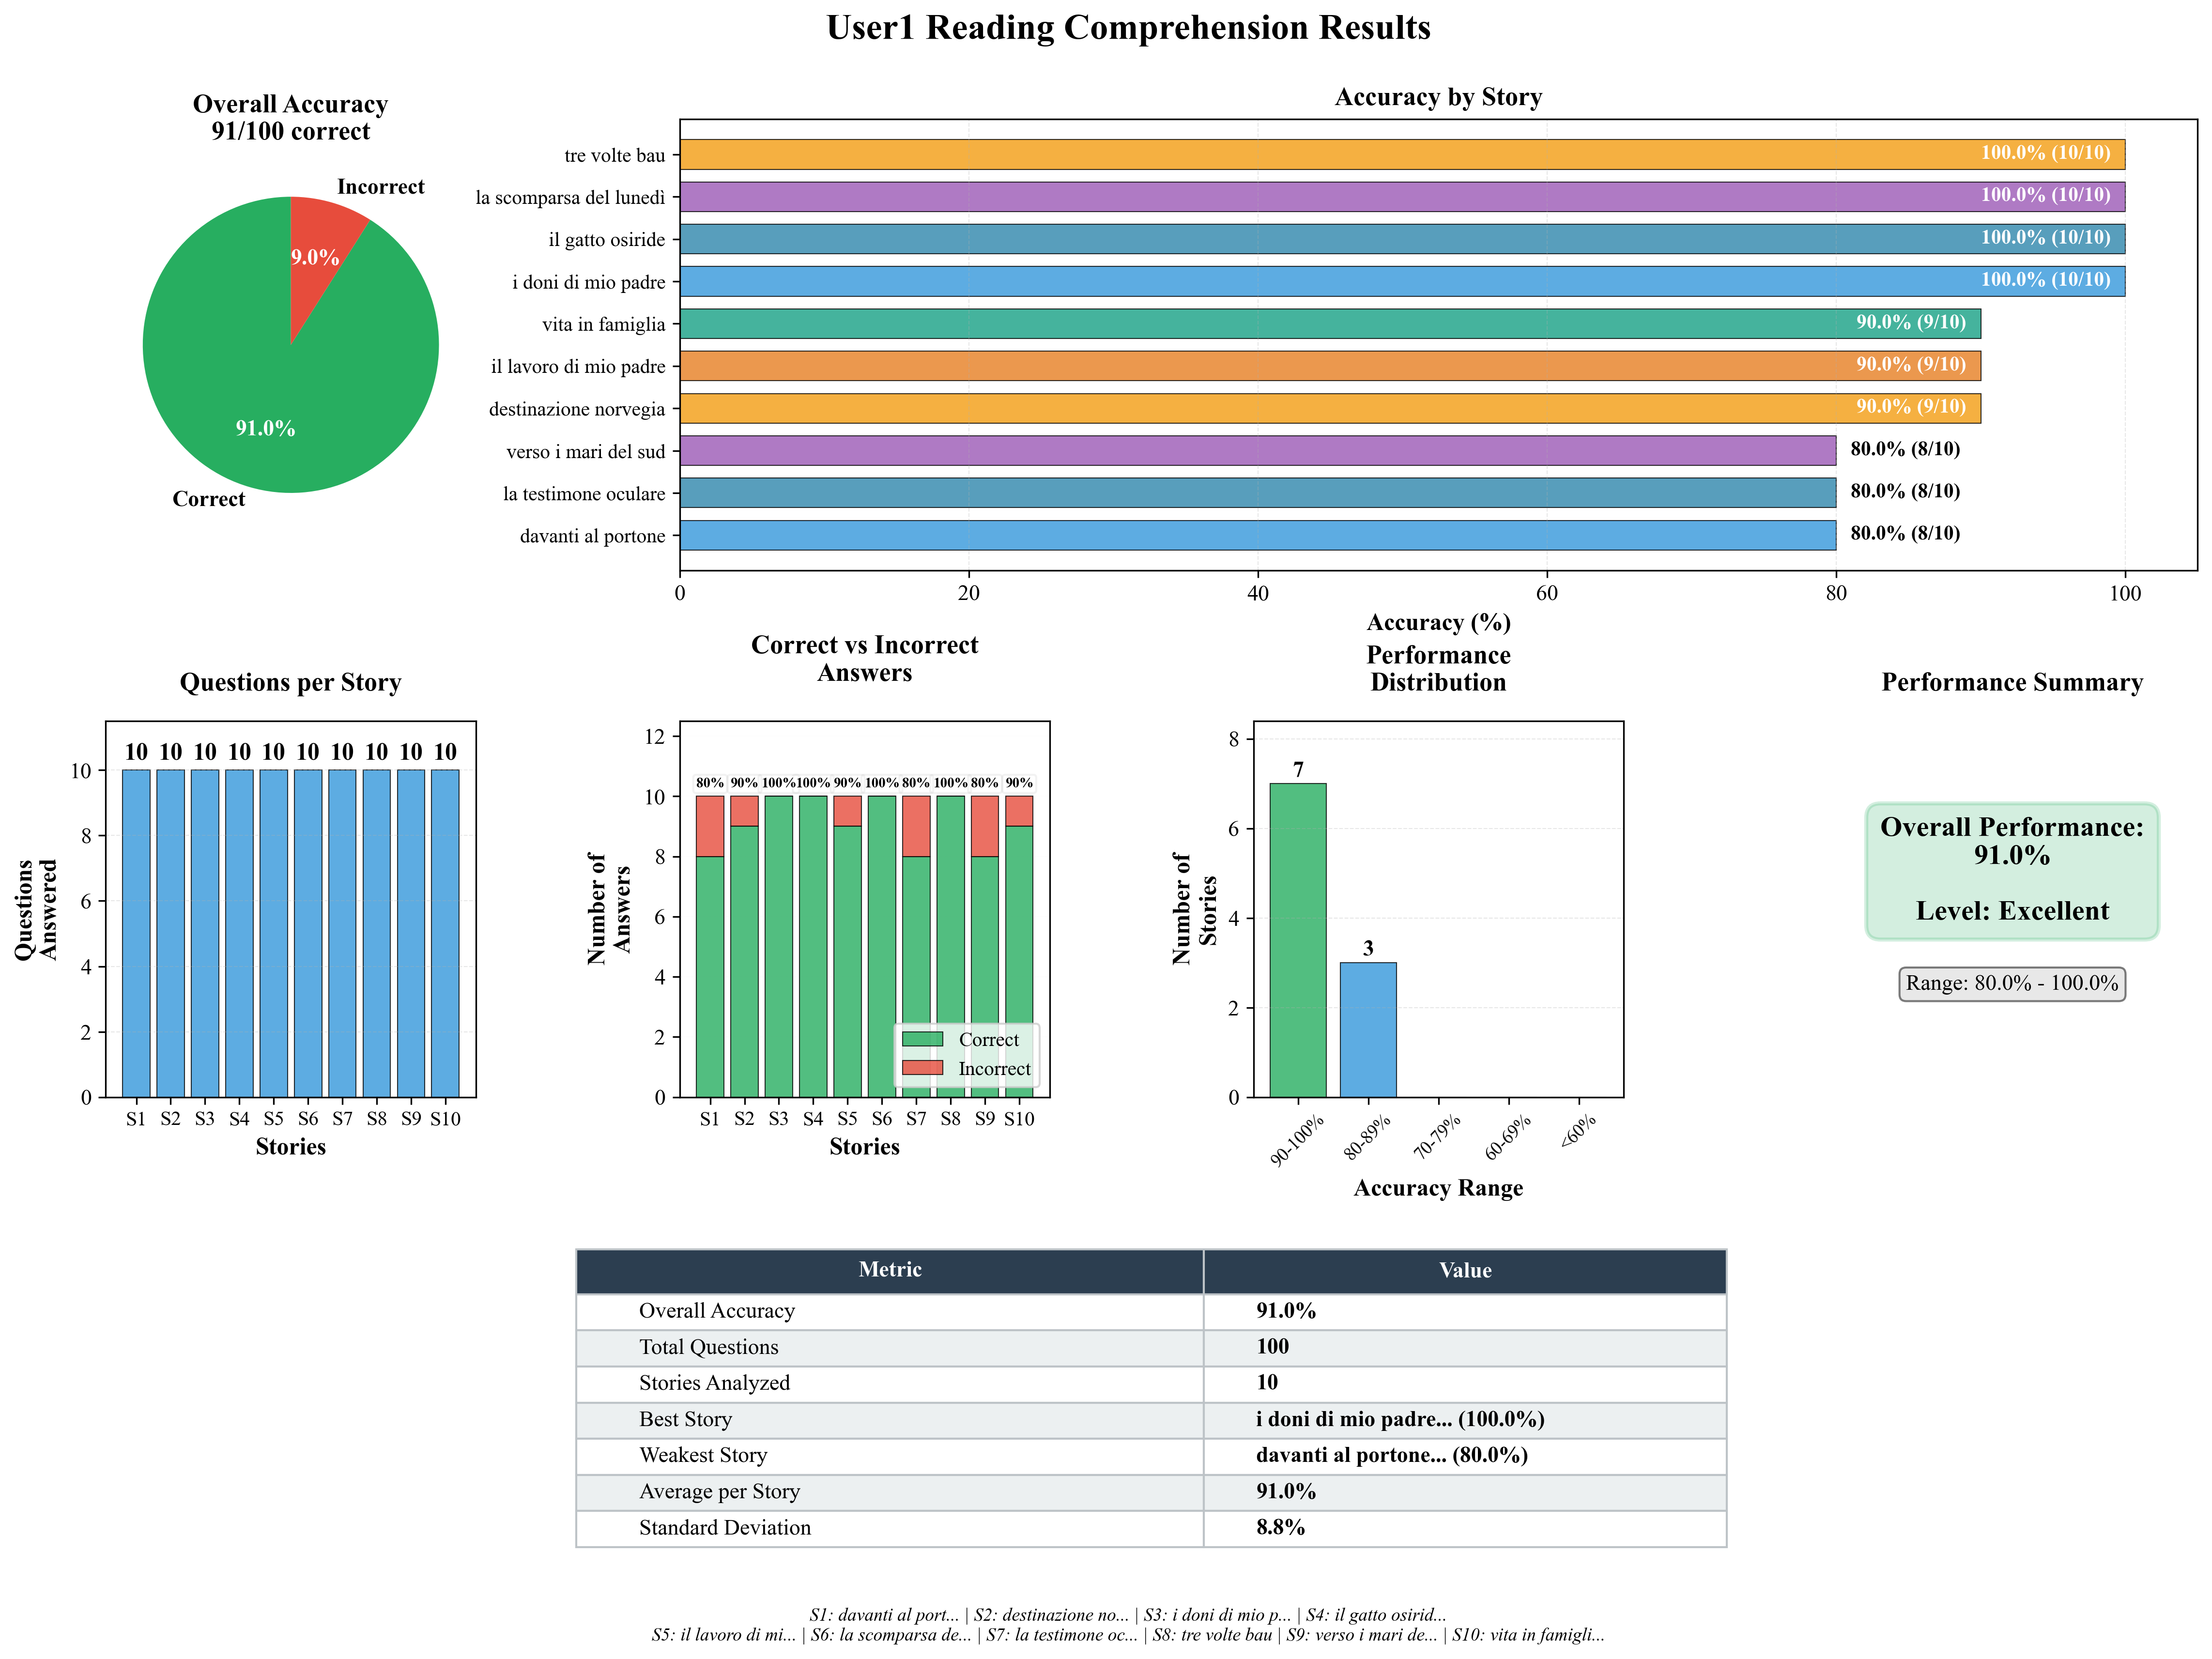

Generating summary...
USER1 PERFORMANCE ANALYSIS
Overall Accuracy: 91.0%
Questions Analyzed: 100
Stories Covered: 10
Question Coverage: 100/170 (58.8%)
Best Performance: 100.0% (i doni di mio padre)
Lowest Performance: 80.0% (davanti al portone)

Story-by-Story Breakdown:
• davanti al portone: 8/10 (80.0%)
• destinazione norvegia: 9/10 (90.0%)
• i doni di mio padre: 10/10 (100.0%)
• il gatto osiride: 10/10 (100.0%)
• il lavoro di mio padre: 9/10 (90.0%)
• la scomparsa del lunedì: 10/10 (100.0%)
• la testimone oculare: 8/10 (80.0%)
• tre volte bau: 10/10 (100.0%)
• verso i mari del sud: 8/10 (80.0%)
• vita in famiglia: 9/10 (90.0%)

Preparing temporal analysis...
Successfully loaded data from: /Users/Martina.Galletti/Downloads/dati-artis1

TEMPORAL ANALYSIS: IMPROVEMENT OVER TIME
Total attempts analyzed: 235
Date range: 2025-07-28 17:38:38 to 2025-10-10 14:26:11


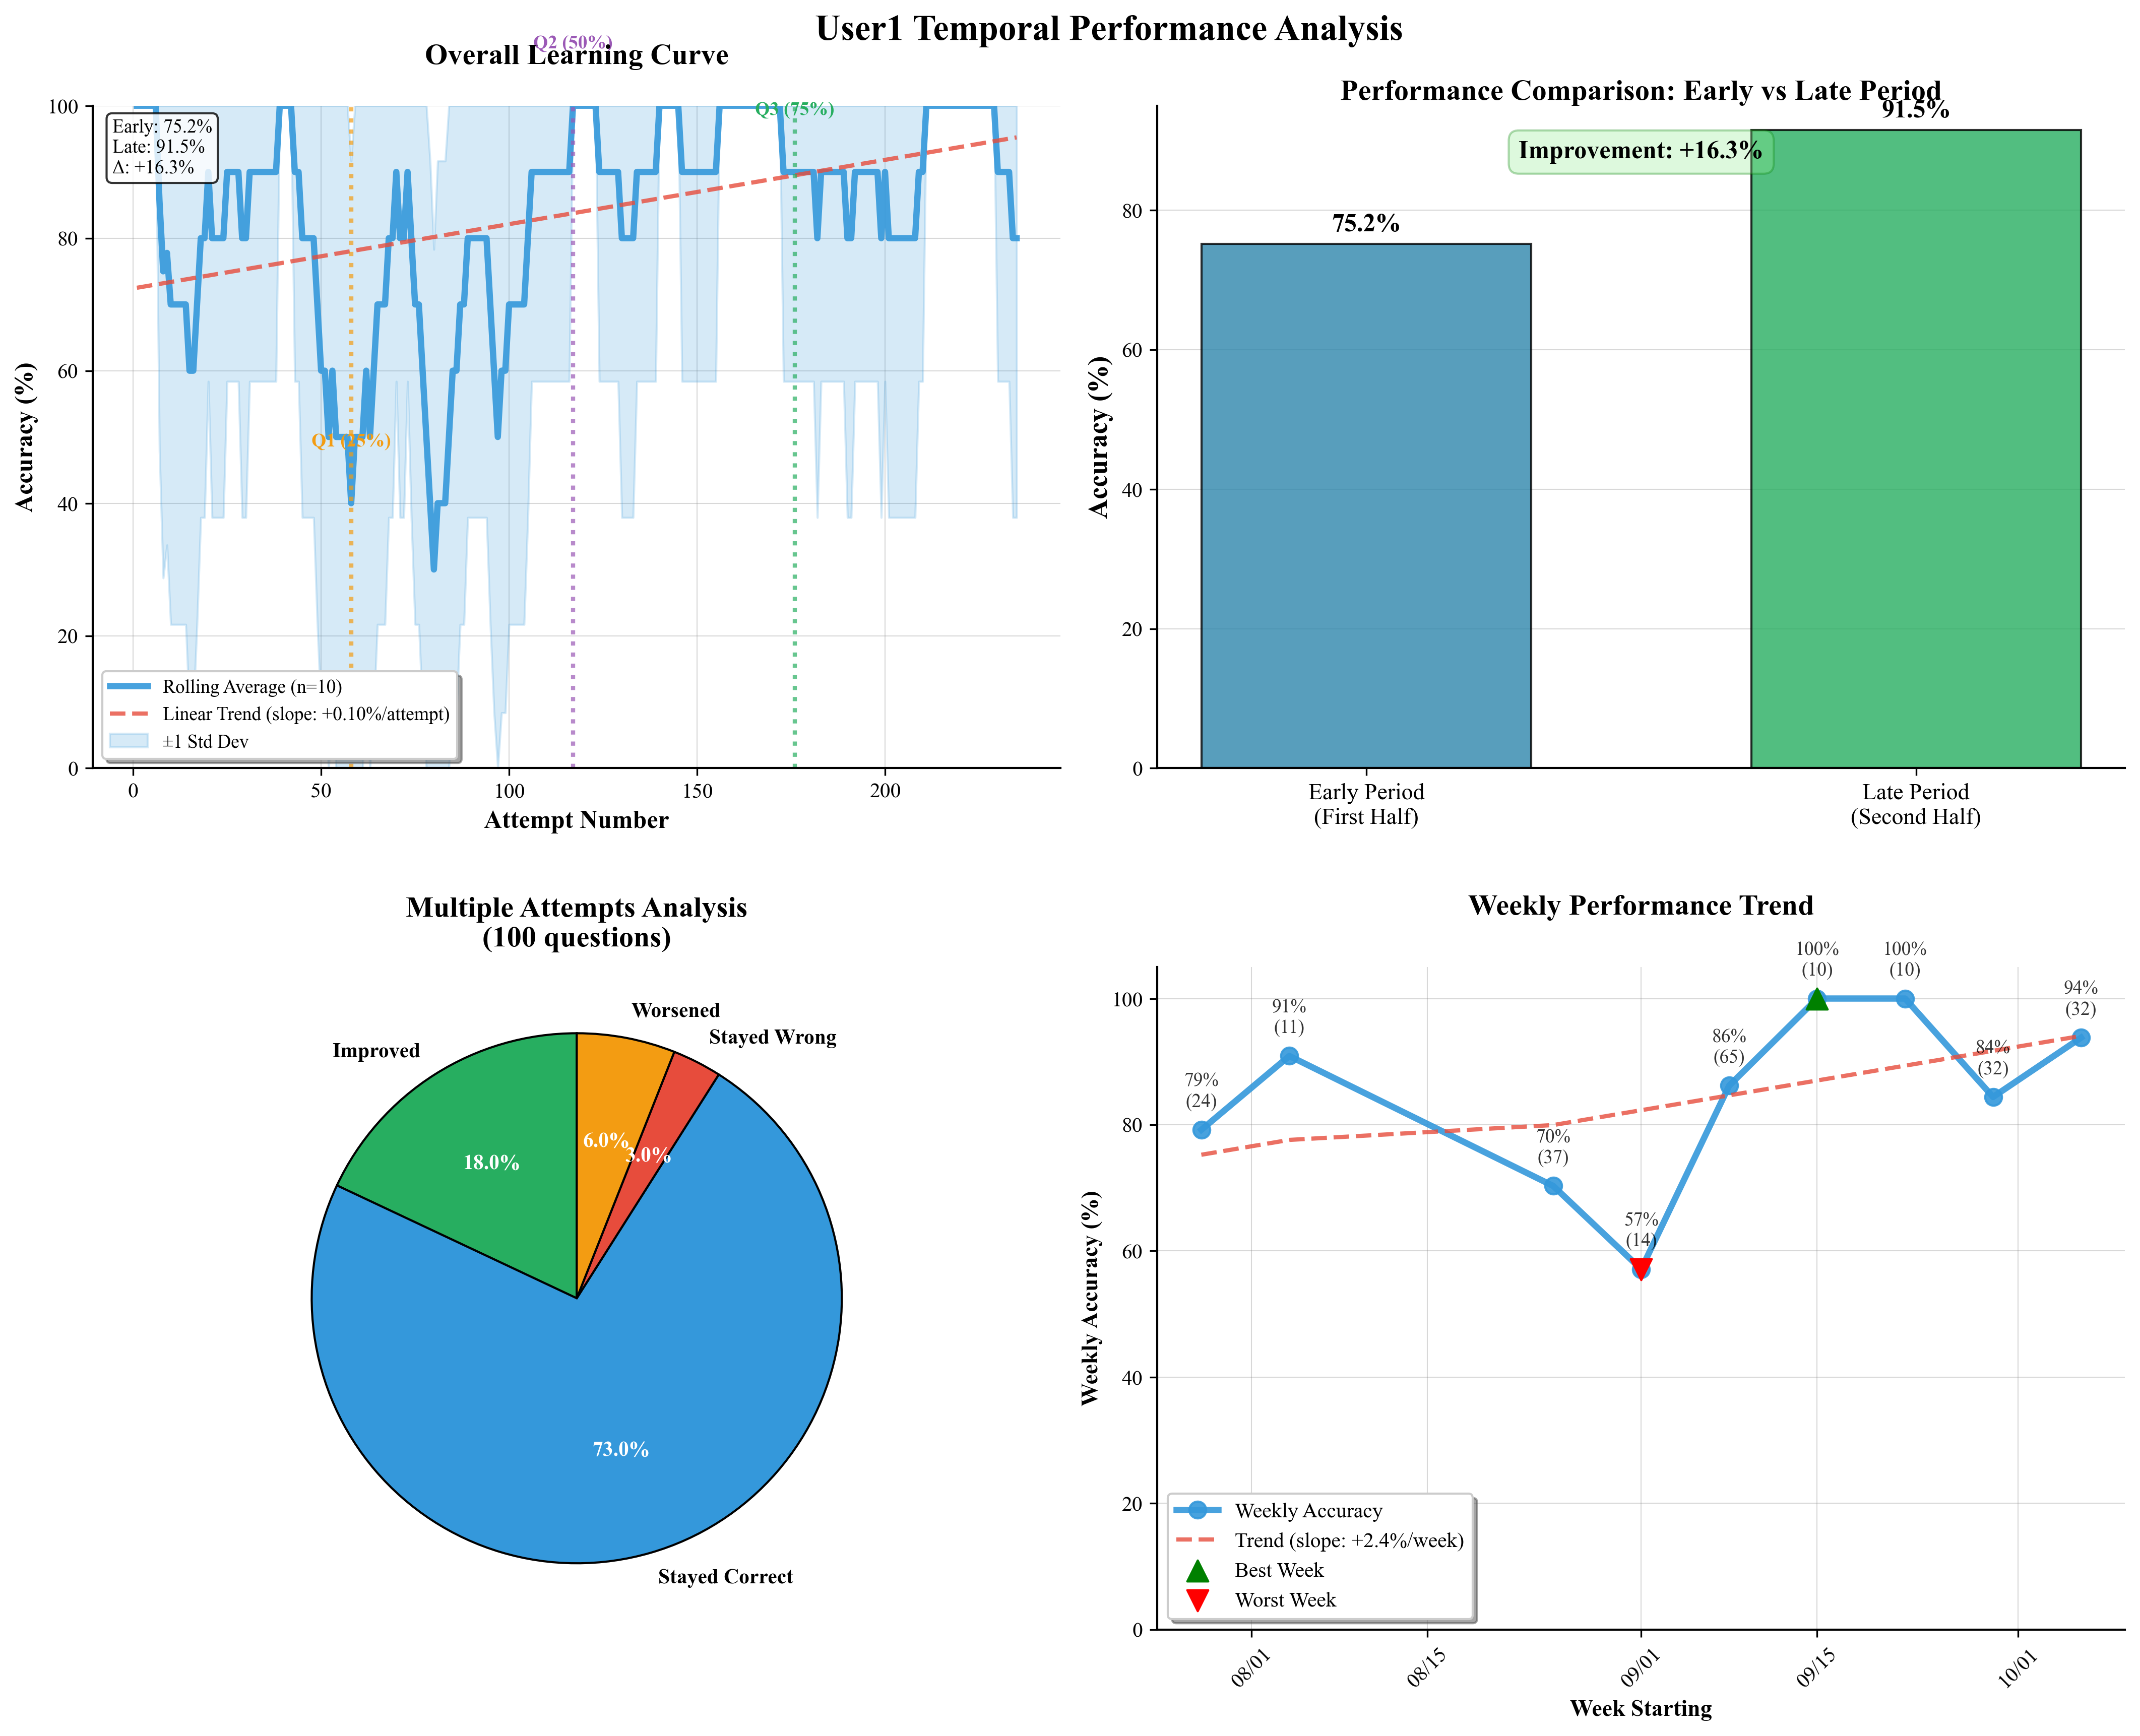


TEMPORAL STATISTICS:
First attempt date: 2025-07-28 17:38:38
Last attempt date: 2025-10-10 14:26:11
Total study period: 73 days
Total attempts: 235
Average attempts per day: 3.2

PERFORMANCE COMPARISON:
Early period accuracy (first 117 attempts): 75.2%
Late period accuracy (last 118 attempts): 91.5%
Improvement: +16.3 percentage points
✅ Significant improvement detected!

STORY-SPECIFIC TEMPORAL TRENDS:
verso i mari del sud: +9.1% change (22 attempts)
davanti al portone: -34.6% change (27 attempts)
destinazione norvegia: +0.0% change (22 attempts)
il gatto osiride: +18.2% change (22 attempts)
i doni di mio padre: +50.0% change (24 attempts)
vita in famiglia: +37.1% change (23 attempts)
la scomparsa del lunedì: +0.0% change (30 attempts)
tre volte bau: +1.5% change (23 attempts)
la testimone oculare: -8.2% change (21 attempts)
il lavoro di mio padre: -18.2% change (21 attempts)

Saving results to CSV files...

CSV FILES SAVED TO: /Users/Martina.Galletti/Downloads/dati-artis1/user1/resu

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
import re
import csv
import os
from datetime import datetime

# Configure matplotlib for professional output
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def load_data(base_path=None):
    """Load and process user and golden datasets with error handling."""
    if base_path is None:
        # For Jupyter notebooks, use the current working directory approach
        try:
            import os
            base_path = os.getcwd()
            # Navigate up to find the correct base directory
            while not os.path.exists(os.path.join(base_path, "dati-json")) and base_path != "/":
                base_path = os.path.dirname(base_path)
            
            # If we didn't find it, use the hardcoded path as fallback
            if not os.path.exists(os.path.join(base_path, "dati-json")):
                base_path = "/Users/Martina.Galletti/Downloads/dati-artis1"
                
        except Exception:
            # Fallback to hardcoded path
            base_path = "/Users/Martina.Galletti/Downloads/dati-artis1"
    
    try:
        user_file = os.path.join(base_path, "dati-json", "risultati-user1.json")
        golden_file = os.path.join(base_path, "json-with-correct-answers", "quinta-elementare_with_answers.json")
        
        # Check if files exist before trying to open them
        if not os.path.exists(user_file):
            print(f"Error: User data file not found at {user_file}")
            return None, None
        
        if not os.path.exists(golden_file):
            print(f"Error: Golden data file not found at {golden_file}")
            return None, None
        
        with open(user_file, "r", encoding='utf-8') as f:
            user_data = json.load(f)
        
        with open(golden_file, "r", encoding='utf-8') as f:
            golden_data = json.load(f)
        
        print(f"Successfully loaded data from: {base_path}")
        return user_data, golden_data
    
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None, None
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON format - {e}")
        return None, None
    except Exception as e:
        print(f"Unexpected error loading data: {e}")
        return None, None


def process_user_data(user_data, exclude_last_n=2):
    """Process user data into DataFrame with enhanced error handling."""
    if not user_data:
        print("Error: No user data provided")
        return pd.DataFrame()
    
    records = []
    
    # Validate data structure
    stories_key = "stories" if "stories" in user_data else "texts"
    if stories_key not in user_data:
        print("Error: Neither 'stories' nor 'texts' found in user data")
        return pd.DataFrame()
    
    all_stories = user_data[stories_key]
    if not all_stories:
        print("Warning: No stories/texts found in data")
        return pd.DataFrame()
    
    # Get stories to process with validation
    if exclude_last_n > 0 and len(all_stories) > exclude_last_n:
        stories_to_process = all_stories[:-exclude_last_n]
        try:
            excluded_titles = [story.get("title", "Unknown") for story in all_stories[-exclude_last_n:]]
            print(f"Total stories/texts in data: {len(all_stories)}")
            print(f"Processing stories/texts (excluding last {exclude_last_n}): {len(stories_to_process)}")
            print(f"Excluded texts: {excluded_titles}")
        except (KeyError, TypeError) as e:
            print(f"Warning: Error accessing story titles: {e}")
    else:
        stories_to_process = all_stories
        print(f"Processing all {len(all_stories)} stories/texts")
    
    for story in stories_to_process:
        if not isinstance(story, dict):
            print(f"Warning: Invalid story format, skipping: {story}")
            continue
            
        title = story.get("title", "Unknown Story")
        
        # Handle questions structure with validation
        questions = story.get("questions", [])
        if not questions and "exercises" in story:
            for exercise in story.get("exercises", []):
                if isinstance(exercise, dict):
                    questions.extend(exercise.get("questions", []))
        
        for q in questions:
            if not isinstance(q, dict):
                continue
                
            q_text = q.get("question", "").strip()
            if not q_text:
                continue
                
            for ans in q.get("answers", []):
                if not isinstance(ans, dict):
                    continue
                    
                try:
                    # Enhanced date parsing with error handling
                    date_str = ans.get("date", "")
                    if not date_str or "->" not in date_str:
                        print(f"Warning: Invalid date format in answer: {date_str}")
                        continue
                        
                    start_time = date_str.split("->")[0].strip()
                    date = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
                    
                    answer_text = ans.get("result", "").strip().lower()
                    if not answer_text:
                        print(f"Warning: Empty answer found for question: {q_text[:50]}...")
                        continue
                    
                    records.append({
                        "title": title,
                        "question": q_text,
                        "answer": answer_text,
                        "date": date
                    })
                    
                except (ValueError, KeyError, AttributeError, IndexError) as e:
                    print(f"Warning: Error processing answer - {e}")
                    continue
    
    if not records:
        print("Warning: No valid records found")
        return pd.DataFrame()
    
    return pd.DataFrame(records)

def process_golden_data(golden_data):
    """Process golden data into DataFrame with error handling."""
    if not golden_data:
        print("Error: No golden data provided")
        return pd.DataFrame()
    
    records = []
    
    # Validate data structure
    stories_key = "stories" if "stories" in golden_data else "texts"
    if stories_key not in golden_data:
        print("Error: Neither 'stories' nor 'texts' found in golden data")
        return pd.DataFrame()
    
    for story in golden_data[stories_key]:
        if not isinstance(story, dict):
            continue
            
        title = story.get("title", "Unknown Story")
        
        # Handle questions structure with validation
        questions = story.get("questions", [])
        if not questions and "exercises" in story:
            for exercise in story.get("exercises", []):
                if isinstance(exercise, dict):
                    questions.extend(exercise.get("questions", []))
        
        for q in questions:
            if not isinstance(q, dict):
                continue
                
            q_text = q.get("question", "").strip()
            if not q_text:
                continue
                
            correct_answer = ""
            if "correct_answer" in q and isinstance(q["correct_answer"], dict):
                correct_answer = q["correct_answer"].get("text", "").strip().lower()
            
            if correct_answer:
                records.append({
                    "title": title,
                    "question": q_text,
                    "correct_answer": correct_answer
                })
    
    if not records:
        print("Warning: No valid golden records found")
        return pd.DataFrame()
    
    return pd.DataFrame(records)

def filter_data(df_user):
    """Filter out vocabulary questions and keep only last attempts."""
    if df_user.empty:
        return df_user
    
    # Remove vocabulary questions
    df_filtered = df_user[~df_user['question'].str.contains("Cosa significa", case=False, na=False)].copy()
    
    if df_filtered.empty:
        print("Warning: No data remaining after filtering vocabulary questions")
        return df_filtered
    
    # Keep only last attempt for each question
    df_last = df_filtered.sort_values('date').groupby(['title', 'question']).tail(1).reset_index(drop=True)
    
    return df_last

def calculate_user_accuracy_improvement(user_data):
    """Calculate accuracy improvement (Late - Early period) for user data using temporal approach"""
    # Look for temporal data file which contains 'is_correct' column
    temporal_file = None
    for filename, df in user_data.items():
        if 'temporal' in filename.lower() and 'is_correct' in df.columns:
            temporal_file = filename
            break
    
    if temporal_file is None:
        print(f"No temporal file with 'is_correct' column found")
        return None, None, None
    
    df_temporal = user_data[temporal_file]
    
    if len(df_temporal) == 0:
        return None, None, None
    
    # Sort by date if date column exists, otherwise use order as-is
    if 'date' in df_temporal.columns:
        df_temporal = df_temporal.sort_values('date')
    
    # Split into early and late periods (same approach as user1.ipynb)
    total_attempts = len(df_temporal)
    early_attempts = df_temporal.iloc[:total_attempts//2]
    late_attempts = df_temporal.iloc[total_attempts//2:]
    
    early_accuracy = early_attempts['is_correct'].mean() * 100
    late_accuracy = late_attempts['is_correct'].mean() * 100
    accuracy_improvement = late_accuracy - early_accuracy
    
    print(f"Found temporal data with {total_attempts} attempts")
    print(f"Early accuracy: {early_accuracy:.2f}%, Late accuracy: {late_accuracy:.2f}%")
    print(f"Accuracy improvement: {accuracy_improvement:.2f}%")
    
    return accuracy_improvement, early_accuracy, late_accuracy

def prepare_temporal_data(df_user, df_golden, exclude_last_n=2):
    """Prepare data for temporal analysis with error handling."""
    try:
        # Get user data with excluded texts for consistency
        user_data, _ = load_data()
        if user_data is None:
            return pd.DataFrame()
            
        df_user_filtered = df_user.copy()
        df_user_all_attempts = df_user_filtered[~df_user_filtered['question']
    .str.contains("Cosa significa", case=False, na=False)].copy()
        df_temporal = df_user_all_attempts.merge(df_golden, on=['title','question'], how='inner')  
        
        # Merge with golden answers to get correctness for all attempts
        df_temporal = df_user_all_attempts.merge(df_golden, on=['title', 'question'], how='inner')
        
        if df_temporal.empty:
            return pd.DataFrame()
            
        df_temporal['is_correct'] = df_temporal['answer'] == df_temporal['correct_answer']
        
        # Sort by date for temporal analysis
        df_temporal = df_temporal.sort_values('date')
        
        return df_temporal
        
    except Exception as e:
        print(f"Error preparing temporal data: {e}")
        return pd.DataFrame()

def create_temporal_plot(df_temporal):
    """Create comprehensive temporal performance visualization with improved error handling."""
    if df_temporal.empty:
        print("No temporal data available for plotting")
        return 0, 0, 0, {}
    
    print("\nTEMPORAL ANALYSIS: IMPROVEMENT OVER TIME")
    print("=" * 60)
    print(f"Total attempts analyzed: {len(df_temporal)}")
    print(f"Date range: {df_temporal['date'].min()} to {df_temporal['date'].max()}")
    
    # Save current matplotlib parameters
    original_params = plt.rcParams.copy()
    
    try:
        # Set professional plotting parameters
        plt.rcParams.update({
            'font.size': 12,
            'font.family': 'serif',
            'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
            'axes.linewidth': 1.0,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.edgecolor': 'black',
            'axes.labelcolor': 'black',
            'axes.axisbelow': True,
            'xtick.bottom': True,
            'ytick.left': True,
            'xtick.color': 'black',
            'ytick.color': 'black',
            'text.color': 'black',
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'savefig.facecolor': 'white',
            'figure.dpi': 300,
            'savefig.dpi': 300,
            'savefig.bbox': 'tight',
            'grid.alpha': 0.3,
            'grid.color': 'gray'
        })
        
        # Calculate daily accuracy with error handling
        try:
            df_temporal['date_only'] = df_temporal['date'].dt.date
            daily_stats = df_temporal.groupby('date_only').agg({
                'is_correct': ['count', 'sum', 'mean']
            }).round(3)
            daily_stats.columns = ['total_attempts', 'correct_attempts', 'daily_accuracy']
            daily_stats['daily_accuracy_pct'] = daily_stats['daily_accuracy'] * 100
        except Exception as e:
            print(f"Error calculating daily stats: {e}")
            return 0, 0, 0, {}
        
        # Create the temporal analysis plot
        fig = plt.figure(figsize=(16, 12), facecolor='white')
        
        # Create grid layout
        gs = fig.add_gridspec(2, 2, 
                             height_ratios=[1, 1], 
                             width_ratios=[1, 1],
                             hspace=0.3, 
                             wspace=0.1,
                             top=0.92,
                             bottom=0.08,
                             left=0.08,
                             right=0.92)
        
        # Professional color palette
        colors_comparison = ['#2E86AB', '#27AE60']
        colors_pie = ['#27AE60', '#3498DB', '#E74C3C', '#F39C12']
        
        # 1. Overall Learning Curve (top left)
        ax1 = fig.add_subplot(gs[0, 0])
        
        # Create overall learning curve with attempt sequence
        attempt_numbers = np.arange(1, len(df_temporal) + 1)
        rolling_window = max(1, min(10, len(df_temporal) // 4))  # Ensure minimum window of 1
        rolling_acc = df_temporal['is_correct'].rolling(window=rolling_window, min_periods=1).mean() * 100
        
        # Plot overall learning curve
        ax1.plot(attempt_numbers, rolling_acc, color='#3498DB', linewidth=3, alpha=0.9,
                 label=f'Rolling Average (n={rolling_window})')
        
        # Add overall trend line with error handling
        if len(attempt_numbers) > 5:
            try:
                z = np.polyfit(attempt_numbers, rolling_acc, 1)
                p = np.poly1d(z)
                trend_line = p(attempt_numbers)
                ax1.plot(attempt_numbers, trend_line, "--", color='#E74C3C', alpha=0.8, linewidth=2,
                         label=f'Linear Trend (slope: {z[0]:+.2f}%/attempt)')
            except Exception as e:
                print(f"Warning: Could not create trend line: {e}")
        
        # Highlight performance quartiles with bounds checking
        if len(attempt_numbers) >= 4:
            quartile_points = [len(attempt_numbers)//4, len(attempt_numbers)//2, 3*len(attempt_numbers)//4]
            quartile_colors = ['#F39C12', '#9B59B6', '#27AE60']
            quartile_labels = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
            
            for i, (point, color, label) in enumerate(zip(quartile_points, quartile_colors, quartile_labels)):
                if point < len(rolling_acc) and point > 0:
                    ax1.axvline(x=point, color=color, linestyle=':', alpha=0.7, linewidth=2)
                    try:
                        ax1.text(point, rolling_acc.iloc[point-1] + 8, label, 
                                ha='center', va='bottom', fontsize=9, color=color, fontweight='bold')
                    except Exception:
                        pass  # Skip label if positioning fails
        
        # Add confidence band with error handling
        try:
            rolling_std = df_temporal['is_correct'].rolling(window=rolling_window, min_periods=1).std() * 100
            ax1.fill_between(attempt_numbers, 
                            np.maximum(0, rolling_acc - rolling_std), 
                            np.minimum(100, rolling_acc + rolling_std),
                            alpha=0.2, color='#3498DB', label='±1 Std Dev')
        except Exception as e:
            print(f"Warning: Could not create confidence band: {e}")
        
        ax1.set_xlabel('Attempt Number', fontweight='bold', fontsize=12)
        ax1.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
        ax1.set_title('Overall Learning Curve', fontsize=14, fontweight='bold', pad=20)
        ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax1.set_ylim(0, 100)
        ax1.legend(fontsize=9, frameon=True, fancybox=True, shadow=False, 
                  bbox_to_anchor=(0, 0), loc='lower left')
        ax1.tick_params(axis='both', labelsize=10)
        
        # Add performance milestones text with safe division
        total_attempts = len(df_temporal)
        if total_attempts >= 2:
            first_half_perf = df_temporal.iloc[:total_attempts//2]['is_correct'].mean() * 100
            second_half_perf = df_temporal.iloc[total_attempts//2:]['is_correct'].mean() * 100
            overall_improvement = second_half_perf - first_half_perf
        else:
            first_half_perf = second_half_perf = overall_improvement = 0
        
        milestone_text = f"Early: {first_half_perf:.1f}%\nLate: {second_half_perf:.1f}%\nΔ: {overall_improvement:+.1f}%"
        ax1.text(0.02, 0.98, milestone_text, transform=ax1.transAxes, fontsize=9,
                 verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # 2. Performance Comparison (Early vs Late) (top right)
        ax2 = fig.add_subplot(gs[0, 1])
        
        if total_attempts >= 2:
            early_attempts = df_temporal.iloc[:total_attempts//2]
            late_attempts = df_temporal.iloc[total_attempts//2:]
            
            early_accuracy = early_attempts['is_correct'].mean() * 100
            late_accuracy = late_attempts['is_correct'].mean() * 100
        else:
            early_accuracy = late_accuracy = df_temporal['is_correct'].mean() * 100 if not df_temporal.empty else 0
        
        # Create comparison bars
        periods = ['Early Period\n(First Half)', 'Late Period\n(Second Half)']
        accuracies = [early_accuracy, late_accuracy]
        
        bars = ax2.bar(periods, accuracies, color=colors_comparison, alpha=0.8, width=0.6, 
                       edgecolor='black', linewidth=1)
        ax2.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=13)
        ax2.set_title('Performance Comparison: Early vs Late Period', fontsize=14, fontweight='bold', pad=3)
        ax2.set_ylim(0, 95)
        ax2.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
        ax2.tick_params(axis='x', labelsize=11)
        ax2.tick_params(axis='y', labelsize=10)
        
        # Add value labels and improvement indicator
        for i, (bar, acc) in enumerate(zip(bars, accuracies)):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                    f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        # Add improvement text
        improvement = late_accuracy - early_accuracy
        if improvement > 0:
            ax2.text(0.50, 0.93, f'Improvement: +{improvement:.1f}%', 
                    transform=ax2.transAxes, ha='center', va='center', fontweight='bold', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.4", facecolor='lightgreen', alpha=0.3, edgecolor='green'))
        else:
            ax2.text(0.50, 0.93, f'Change: {improvement:.1f}%', 
                    transform=ax2.transAxes, ha='center', va='center', fontweight='bold', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral', alpha=0.3, edgecolor='red'))
        
        # 3. Multiple Attempts Analysis (bottom left)
        ax3 = fig.add_subplot(gs[1, 0])
        
        try:
            questions_with_multiple = df_temporal.groupby(['title', 'question']).size()
            multiple_attempts_questions = questions_with_multiple[questions_with_multiple > 1]
        except Exception as e:
            print(f"Error analyzing multiple attempts: {e}")
            multiple_attempts_questions = pd.Series(dtype=int)
        
        if len(multiple_attempts_questions) > 0:
            # Analyze improvement patterns
            improvement_patterns = {'Improved': 0, 'Stayed Correct': 0, 'Stayed Wrong': 0, 'Worsened': 0}
            
            for (title, question), count in multiple_attempts_questions.items():
                try:
                    question_attempts = df_temporal[
                        (df_temporal['title'] == title) & 
                        (df_temporal['question'] == question)
                    ].sort_values('date')
                    
                    if len(question_attempts) >= 2:
                        first_correct = question_attempts.iloc[0]['is_correct']
                        last_correct = question_attempts.iloc[-1]['is_correct']
                        
                        if first_correct and last_correct:
                            improvement_patterns['Stayed Correct'] += 1
                        elif not first_correct and last_correct:
                            improvement_patterns['Improved'] += 1
                        elif not first_correct and not last_correct:
                            improvement_patterns['Stayed Wrong'] += 1
                        else:
                            improvement_patterns['Worsened'] += 1
                except Exception as e:
                    print(f"Warning: Error processing question attempts: {e}")
                    continue
            
            # Create pie chart
            labels = list(improvement_patterns.keys())
            sizes = list(improvement_patterns.values())
            
            if sum(sizes) > 0:
                wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie,
                                                  autopct='%1.1f%%', startangle=90,
                                                  textprops={'fontsize': 11},
                                                  wedgeprops={'edgecolor': 'black', 'linewidth': 1})
                
                for autotext in autotexts:
                    autotext.set_color('white')
                    autotext.set_fontweight('bold')
                    autotext.set_fontsize(10)
                
                for text in texts:
                    text.set_fontsize(10)
                    text.set_fontweight('bold')
            
            ax3.set_title(f'Multiple Attempts Analysis\n({len(multiple_attempts_questions)} questions)', 
                          fontsize=14, fontweight='bold', pad=10)
            
        else:
            ax3.text(0.5, 0.5, 'No Multiple\nAttempts Found', ha='center', va='center',
                    transform=ax3.transAxes, fontsize=14, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.5))
            ax3.set_title('Multiple Attempts Analysis', fontsize=14, fontweight='bold', pad=20)
            multiple_attempts_questions = {}
        
        # 4. Weekly Trend Analysis (bottom right)
        ax4 = fig.add_subplot(gs[1, 1])
        
        try:
            # Calculate weekly performance
            df_temporal['week_start'] = df_temporal['date'].dt.to_period('W').dt.start_time
            weekly_stats = df_temporal.groupby('week_start').agg({
                'is_correct': ['count', 'sum', 'mean']
            }).round(3)
            weekly_stats.columns = ['total_attempts', 'correct_attempts', 'weekly_accuracy']
            weekly_stats['weekly_accuracy_pct'] = weekly_stats['weekly_accuracy'] * 100
            
            # Filter weeks with at least 2 attempts for more reliable data
            weekly_stats_filtered = weekly_stats[weekly_stats['total_attempts'] >= 2]
            
            if len(weekly_stats_filtered) >= 2:
                # Plot weekly accuracy trend
                ax4.plot(weekly_stats_filtered.index, weekly_stats_filtered['weekly_accuracy_pct'], 
                         color='#3498DB', linewidth=3, marker='o', markersize=8, alpha=0.9,
                         label='Weekly Accuracy')
                
                # Add trend line with error handling
                try:
                    x_numeric = np.arange(len(weekly_stats_filtered))
                    z = np.polyfit(x_numeric, weekly_stats_filtered['weekly_accuracy_pct'], 1)
                    p = np.poly1d(z)
                    trend_line = p(x_numeric)
                    ax4.plot(weekly_stats_filtered.index, trend_line, "--", color='#E74C3C', 
                             alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:+.1f}%/week)')
                except Exception as e:
                    print(f"Warning: Could not create weekly trend line: {e}")
                
                # Highlight best and worst weeks with error handling
                try:
                    best_week_idx = weekly_stats_filtered['weekly_accuracy_pct'].idxmax()
                    worst_week_idx = weekly_stats_filtered['weekly_accuracy_pct'].idxmin()
                    
                    ax4.scatter([best_week_idx], [weekly_stats_filtered.loc[best_week_idx, 'weekly_accuracy_pct']], 
                               color='green', s=100, marker='^', zorder=5, label='Best Week')
                    ax4.scatter([worst_week_idx], [weekly_stats_filtered.loc[worst_week_idx, 'weekly_accuracy_pct']], 
                               color='red', s=100, marker='v', zorder=5, label='Worst Week')
                except Exception as e:
                    print(f"Warning: Could not highlight best/worst weeks: {e}")
                
                # Add value labels for each point with error handling
                for idx, row in weekly_stats_filtered.iterrows():
                    try:
                        ax4.text(idx, row['weekly_accuracy_pct'] + 3, 
                                f"{row['weekly_accuracy_pct']:.0f}%\n({int(row['total_attempts'])})", 
                                ha='center', va='bottom', fontsize=9, alpha=0.8)
                    except Exception:
                        pass  # Skip label if positioning fails
                
                ax4.set_xlabel('Week Starting', fontweight='bold', fontsize=11)
                ax4.set_ylabel('Weekly Accuracy (%)', fontweight='bold', fontsize=11)
                ax4.set_title('Weekly Performance Trend', fontsize=14, fontweight='bold', pad=25)
                ax4.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
                ax4.set_ylim(0, 105)
                ax4.legend(fontsize=10, frameon=True, fancybox=True, shadow=False)
                
                # Format x-axis to show dates nicely
                ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
                ax4.tick_params(axis='x', rotation=45, labelsize=10)
                ax4.tick_params(axis='y', labelsize=10)
                
            else:
                # Fallback for insufficient weekly data
                daily_stats_viz = daily_stats[daily_stats['total_attempts'] >= 1]
                
                if len(daily_stats_viz) > 0:
                    ax4.bar(range(len(daily_stats_viz)), daily_stats_viz['daily_accuracy_pct'], 
                           color='#3498DB', alpha=0.7, width=0.8)
                    
                    ax4.set_xlabel('Study Days', fontweight='bold', fontsize=13)
                    ax4.set_ylabel('Daily Accuracy (%)', fontweight='bold', fontsize=13)
                    ax4.set_title('Daily Performance Pattern', fontsize=14, fontweight='bold', pad=20)
                    ax4.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)
                    ax4.set_ylim(0, 105)
                    ax4.set_xticks(range(len(daily_stats_viz)))
                    ax4.set_xticklabels([f'Day {i+1}' for i in range(len(daily_stats_viz))], fontsize=10)
                    
                    # Add value labels on bars
                    for i, (idx, row) in enumerate(daily_stats_viz.iterrows()):
                        try:
                            ax4.text(i, row['daily_accuracy_pct'] + 2, 
                                    f"{row['daily_accuracy_pct']:.0f}%", 
                                    ha='center', va='bottom', fontweight='bold', fontsize=9)
                        except Exception:
                            pass
                else:
                    ax4.text(0.5, 0.5, 'Insufficient\nData for\nTrend Analysis', 
                            ha='center', va='center', transform=ax4.transAxes, 
                            fontsize=12, fontweight='bold')
                    ax4.set_title('Weekly Performance Trend', fontsize=14, fontweight='bold', pad=25)
        
        except Exception as e:
            print(f"Error in weekly analysis: {e}")
            ax4.text(0.5, 0.5, 'Error in\nWeekly Analysis', ha='center', va='center',
                    transform=ax4.transAxes, fontsize=12, fontweight='bold')
            ax4.set_title('Weekly Performance Trend', fontsize=14, fontweight='bold', pad=25)
        
        ax4.tick_params(axis='both', labelsize=10)
        
        # Add main title
        fig.suptitle('User1 Temporal Performance Analysis', 
                    fontsize=17, fontweight='bold', y=0.97, ha='center')
        
        plt.show()
        
        return early_accuracy, late_accuracy, improvement, multiple_attempts_questions
    
    except Exception as e:
        print(f"Error creating temporal plot: {e}")
        return 0, 0, 0, {}
    
    finally:
        # Restore original matplotlib parameters
        plt.rcParams.update(original_params)

def print_temporal_summary(df_temporal, early_accuracy, late_accuracy, improvement, multiple_attempts_questions):
    """Print detailed temporal statistics with error handling."""
    if df_temporal.empty:
        print("No temporal data available for summary")
        return
    
    try:
        total_attempts = len(df_temporal)
        
        # Safe division for date range
        date_range_days = (df_temporal['date'].max() - df_temporal['date'].min()).days
        avg_attempts_per_day = len(df_temporal) / max(1, date_range_days) if date_range_days > 0 else len(df_temporal)
        
        print("\nTEMPORAL STATISTICS:")
        print("=" * 40)
        print(f"First attempt date: {df_temporal['date'].min()}")
        print(f"Last attempt date: {df_temporal['date'].max()}")
        print(f"Total study period: {date_range_days} days")
        print(f"Total attempts: {total_attempts}")
        print(f"Average attempts per day: {avg_attempts_per_day:.1f}")
        
        # Safe calculation for early/late periods
        if total_attempts >= 2:
            early_attempts = df_temporal.iloc[:total_attempts//2]
            late_attempts = df_temporal.iloc[total_attempts//2:]
        else:
            early_attempts = late_attempts = df_temporal
        
        print(f"\nPERFORMANCE COMPARISON:")
        print(f"Early period accuracy (first {len(early_attempts)} attempts): {early_accuracy:.1f}%")
        print(f"Late period accuracy (last {len(late_attempts)} attempts): {late_accuracy:.1f}%")
        print(f"Improvement: {improvement:+.1f} percentage points")
        
        if improvement > 5:
            print("✅ Significant improvement detected!")
        elif improvement > 0:
            print("📈 Slight improvement detected")
        elif improvement > -5:
            print("📊 Performance remained stable")
        else:
            print("📉 Performance declined")
        
        # Story-specific temporal analysis with error handling
        print(f"\nSTORY-SPECIFIC TEMPORAL TRENDS:")
        print("=" * 40)
        
        for title in df_temporal['title'].unique():
            try:
                story_data = df_temporal[df_temporal['title'] == title].sort_values('date')
                if len(story_data) > 1:
                    story_midpoint = len(story_data) // 2
                    if story_midpoint > 0:
                        first_accuracy = story_data.iloc[:story_midpoint]['is_correct'].mean() * 100
                        last_accuracy = story_data.iloc[story_midpoint:]['is_correct'].mean() * 100
                        story_trend = last_accuracy - first_accuracy
                        title_display = title[:30] + "..." if len(title) > 30 else title
                        print(f"{title_display}: {story_trend:+.1f}% change ({len(story_data)} attempts)")
            except Exception as e:
                print(f"Error analyzing story {title[:20]}...: {e}")
                continue
        
        # Multiple attempts analysis with error handling
        if isinstance(multiple_attempts_questions, dict) and len(multiple_attempts_questions) > 0:
            print(f"\nMULTIPLE ATTEMPTS ANALYSIS:")
            print("=" * 40)
            print(f"Questions attempted multiple times: {len(multiple_attempts_questions)}")
            
            # Analyze improvement in repeated questions
            improvement_count = 0
            total_repeated = 0
            
            for (title, question), count in multiple_attempts_questions.items():
                try:
                    question_attempts = df_temporal[
                        (df_temporal['title'] == title) & 
                        (df_temporal['question'] == question)
                    ].sort_values('date')
                    
                    if len(question_attempts) >= 2:
                        first_correct = question_attempts.iloc[0]['is_correct']
                        last_correct = question_attempts.iloc[-1]['is_correct']
                        
                        if last_correct and not first_correct:
                            improvement_count += 1
                        total_repeated += 1
                except Exception as e:
                    print(f"Warning: Error analyzing repeated question: {e}")
                    continue
            
            if total_repeated > 0:
                improvement_rate = (improvement_count / total_repeated) * 100
                print(f"Questions improved from wrong to right: {improvement_count}/{total_repeated} ({improvement_rate:.1f}%)")
            else:
                print("No valid repeated questions found for improvement analysis")
        
    except Exception as e:
        print(f"Error generating temporal summary: {e}")

# ... existing code for create_professional_plot, print_summary, and save_results_to_csv remains the same ...

def main():
    """Main function with comprehensive error handling."""
    try:
        print("Loading data...")
        user_data, golden_data = load_data()
        
        if user_data is None or golden_data is None:
            print("Failed to load data. Exiting.")
            return
        
        print("Processing datasets...")
        df_user = process_user_data(user_data, exclude_last_n=2)
        
        if df_user.empty:
            print("No user data to process. Exiting.")
            return
        
        df_golden = process_golden_data(golden_data)
        
        if df_golden.empty:
            print("No golden data to process. Exiting.")
            return
        
        print("Filtering data (removing vocabulary questions, keeping last attempts)...")
        df_user_clean = filter_data(df_user)
        
        if df_user_clean.empty:
            print("No data remaining after filtering. Exiting.")
            return
        
        print("Calculating accuracy...")
        merged_df, story_accuracy = calculate_accuracy(df_user_clean, df_golden)
        
        if merged_df is not None and story_accuracy is not None:
            overall_accuracy = merged_df['is_correct'].mean() * 100
            
            print("Creating performance visualization...")
            create_professional_plot(merged_df, story_accuracy, df_user_clean, df_golden)
            
            print("Generating summary...")
            print_summary(merged_df, story_accuracy, df_user_clean, df_golden)
            
            # Temporal analysis
            print("\nPreparing temporal analysis...")
            df_temporal = prepare_temporal_data(df_user, df_golden)
            
            if not df_temporal.empty:
                early_accuracy, late_accuracy, improvement, multiple_attempts_questions = create_temporal_plot(df_temporal)
                print_temporal_summary(df_temporal, early_accuracy, late_accuracy, improvement, multiple_attempts_questions)
                
                # Save results to CSV
                print("\nSaving results to CSV files...")
                try:
                    output_dir = save_results_to_csv(
                        merged_df, story_accuracy, df_temporal, overall_accuracy,
                        early_accuracy, late_accuracy, improvement, multiple_attempts_questions
                    )
                except Exception as e:
                    print(f"Error saving CSV files: {e}")
                
            else:
                print("No temporal data available for analysis!")
                # Save basic results without temporal data
                try:
                    output_dir = save_results_to_csv(
                        merged_df, story_accuracy, pd.DataFrame(), overall_accuracy,
                        0, 0, 0, {}
                    )
                except Exception as e:
                    print(f"Error saving basic CSV files: {e}")
            
        else:
            print("No matching questions found for analysis!")
    
    except Exception as e:
        print(f"Critical error in main execution: {e}")
        return

# Run analysis
if __name__ == "__main__":
    main()